# Figures for Barnard 5 at large and small scale

In this notebook, we do the figures for all data, from large scale to small scale and the comparison between them.
These were in two separate notebooks, one for ALMA and another one for NOEMA, but it is more convenient to have all figures in one place.


In [1]:
import numpy as np
import os
from spectral_cube import SpectralCube
from B5setup import * # needs B5setup.py in the same folder
from scipy import stats
import velocity_tools.stream_lines as SL
import pandas as pd

# astropy
from astropy.modeling.models import Gaussian1D
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5
from astropy.visualization.wcsaxes import add_beam, add_scalebar
import aplpy
from regions import Regions

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Circle, Ellipse
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import gridspec
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from copy import copy

%matplotlib inline

figdir = 'figures/'
dpibase = 100
vlsr_irs1 = 10.2 #kms

## Useful functions and definitions

In [2]:
# definition of constants and fuctions

position_IRS1 = [ra_yso, dec_yso]

def degtohoursRA(deg):
    hours = deg / 360 * 24
    hh = np.trunc(hours).astype('int64')
    minutes = ((hours-hh) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(hh, mm, ss)


def degtohoursDEC(deg):
    dd = np.trunc(deg).astype('int64')
    minutes = ((np.abs(deg)-np.abs(dd)) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(dd, mm, ss)

def hourstodegRA(hours, minutes, seconds):
    deg = 15 * hours + 60 * minutes + 60 * seconds    
    return deg

def degtodegDEC(degrees, minutes, seconds):
    deg = degrees + 60 * minutes + 60 * seconds    
    return deg

def getPositionFromRegions(regionfile):
    regionload = Regions.read(regionfile)
    positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value] for i in range(len(regionload))]
    regionlabels = [regionload[i].meta['text'] for i in range(len(regionload))]
    return positions, regionlabels

def get_spectra(cube, position, velstart, velend):
    '''
    Extracts the spectra (velocity, intensity) given a cube.
    
    Returns the spectra of the cube given, in the native units of the cube. 
    
    Args:
        cube (SpectralCube): datacube 
        position (NDarray): array size 2 containing ra and dec
        velstart (astropy.units): initial velocity of the spectra in u.km/u.s
        velend (astropy.units): final velocity of the spectra in u.km/u.s
    '''
    cubenew = cube.spectral_slab(velstart, velend)
    cubehead = cubenew.header
    bmaj = cubehead['bmaj'] * u.deg
    bmin = cubehead['bmin'] * u.deg
    beamarea = (1.133 * bmaj * bmin).to(u.arcsec**2)
    if 'restfreq' in cubehead._keyword_indices:
        restfreq = cubehead['restfreq'] * u.Hz
    else:
        restfreq = cubehead['restfrq'] * u.Hz
    cubewcs = WCS(cubehead)
    ra, dec = np.round(cubewcs.celestial.all_world2pix(position[0], position[1], 0), 0)
#     rah = degtohoursRA(position[0])
#     dech = degtohoursDEC(position[1])
    velocities = cubenew.spectral_axis
    intensities = cubenew[:, int(dec), int(ra)]
    return velocities, intensities

def get_parameters_spectra(paramcube, position, header):
    '''
    This function returns all the contents in the cube along the spectra. 
    This means it returns errors as well if the paramscube includes them
    
    Args:
        paramcube (ndarray): cube with the parameters and errors for each parameter
        position (NDarray): array size 2 containing ra and dec in degrees
        header (SpectralCube.header): header to transform the wcs into pixel positions
    '''
    cubewcs = WCS(header)
    ra, dec = np.round(cubewcs.celestial.wcs_world2pix(position[0], position[1], 0), 0)
    # ra = np.round(ra[0], 0)
    # dec = np.round(dec[0], 0)
    params = paramcube[:, int(dec), int(ra)]
    return params

## NOEMA + 30m observations: HC$_3$N


### Filenames

In [3]:
# HC3N files
filedir = 'B5_NOEMA_30m/'
fitdir = filedir + 'gaussfit/'

# File in K and in km/s
imagefile = filedir + "B5-NOEMA+30m-H3CN-10-9_cut_K"
imagefile_87 = filedir + "B5-NOEMA+30m-H3CN-8-7_cut_K"
smallimagefile = filedir + "B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom"
x0, y0, x1, y1 = 83, 131, 133, 180
mom0file = imagefile + '_int_9.2_11.2.fits'
mom0file87 = imagefile_87 + '_int_9.2_11.2'

rmsKkmsHC3N = 0.15
rmsfile = fitdir +  'B5-NOEMA+30m-H3CN-10-9_cut_K_rms'
snrfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_snr'
tpeakfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_Tpeak'
maskfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_mask'
initguessfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_guesses.fits'
colorHC3N = '#984ea3'
positionfile_south = 'B5_NOEMA_30m/samples_South.reg'
positionfile_north = 'B5_NOEMA_30m/samples_North.reg'

fitfile =  fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_2.fits'
fitfilefiltered = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_2_filtered.fits'
fitfilefiltered_vlsr = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr.fits'
fitfilefiltered_vlsr_conv = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr_conv_NH3.fits'

fitfile2 = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams2.fits'
fitfile2filtered = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams2_filtered.fits'
fitfile2filtered_probfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams_2prob.fits'
fitfile2filtered_maskfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams_2gmask.fits'

# line ratio map
ratiomapfile = filedir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_int_9.2_11.2_convolved_regrid_over_8_7.fits'
ratiomapkdefile = filedir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_int_9.2_11.2_convolved_regrid_over_8_7_kde.npy'
# column density map
Ntotmapfile = filedir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_int_9.2_11.2_Ntot.fits'

In [4]:
# VLA+GBT files from Pineda et al 2015
vlafolder = 'B5_previous_data/'
maskC1file = vlafolder + 'mask_C1.fits'
maskC2file = vlafolder + 'mask_C2.fits'
maskC3file = vlafolder + 'mask_C3.fits'
maskcondfile = vlafolder + 'mask_condensations_NH3_reprojectHC3N.fits'
nh3mom0file = vlafolder + 'B5_VLA_GBT_model_11_mom0_reproject.fits'
nh3mom0levels = [0.1]
nh3velocityfile = vlafolder + 'B5_VLA_GBT_model_vc_QA_reprojectHC3N.fits' # check if using the original for the plot is better
# MASSES survey files from Stephens et al 2019
massesfolder = 'B5_previous_data/'
CO21fileblue = massesfolder + 'Per53.12CO21.robust1_blue.fits'
CO21filered = massesfolder + 'Per53.12CO21.robust1_red.fits'
bluecontlevels = [0.82+i*1.3 for i in range(4)]
redcontlevels = [1.2+i*2.1 for i in range(4)] # in Jy/beam km/s
colorNH3 = '#4daf4a'

### Moment 0 maps of HC$_3$N ($10-9$)

In [ ]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_mom0_9.2_11.2_woutflow.pdf'

gc = plot_aplpy_subfig(mom0file, fig, (1,1,1), 'arcsinh', 0, 2.2, 'viridis', vmid=0.8, showframeScalebar=False)
gc.show_contour(maskC1file, colors='w', linewidths=0.5)
gc.add_label(0.55, 0.55, 'Cond-1', relative=True, color='w', size=12)
gc.show_contour(maskC2file, colors='w', linewidths=0.5)
gc.add_label(0.15, 0.58, 'Cond-2', relative=True, color='w', size=12)
gc.show_contour(maskC3file, colors='w', linewidths=0.5)
gc.add_label(0.35, 0.29, 'Cond-3', relative=True, color='w', size=12)

gc.show_arrows([56.9071283, 56.9275561, 56.9212545, 56.9039327, 56.9074336], 
               [32.8742579, 32.8753517, 32.8564551, 32.8903704, 32.8489104], 
               [0.005, -0.003, 0.006, 0.006, 0.006], [-0.001, -0.008, 0.003, 0, -0.006], color='w', width=1, head_width=4, head_length=4)
# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
gc.add_label(0.6, 0.75, 'Fil-1', relative=True, color='w', size=12)
gc.add_label(0.51, 0.25, 'Fil-2', relative=True, color='w', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.add_label(0.99,0.2, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', relative=True, color='w', size=12, horizontalalignment='right')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
gc.colorbar.set_pad(0.1)
gc.show_rectangles([ra_yso], [dec_yso], 0.0015*2, 0.0015*2, edgecolor='k', facecolor='none', zorder=1000)

# if you want to add the mask contour
# gc.show_contour(maskfile+'.fits', colors='white', linewidths=0.5, levels=[1])
# if you want to add arrows with the direction of the outflow
gc.show_arrows(56.9249180, 32.8636213, 0.005, 0.003, color='w', zorder=100, linewidth=3)
gc.show_arrows(56.9249180, 32.8636213, 0.005, 0.003, color='b', zorder=100)
gc.show_arrows(56.9220945, 32.8616098, -0.005, -0.003, color='w', linewidth=3)
gc.show_arrows(56.9220945, 32.8616098, -0.005, -0.003, color='r', zorder=100)

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

### Moment 0 maps of HC$_3$N ($8-7$)

In [ ]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5-NOEMA+30m-H3CN-8-7_cut_K_mom0_9.2_11.2.pdf'

gc = plot_aplpy_subfig(mom0file87+'.fits', fig, (1,1,1), 'arcsinh', 0, 3, 'viridis', vmid=1, showframeScalebar=True)
# gc.show_contour(maskC1file, colors='w', linewidths=0.5)
# gc.add_label(0.55, 0.55, 'Cond-1', relative=True, color='w', size=12)
# gc.show_contour(maskC2file, colors='w', linewidths=0.5)
# gc.add_label(0.15, 0.58, 'Cond-2', relative=True, color='w', size=12)
# gc.show_contour(maskC3file, colors='w', linewidths=0.5)
# gc.add_label(0.35, 0.29, 'Cond-3', relative=True, color='w', size=12)

# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.add_label(0.99,0.20, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (8 - 7)', relative=True, color='w', size=12, horizontalalignment='right')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
gc.colorbar.set_pad(0.1)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

### Channel maps of HC$_3$N ($10-9$)

In [5]:
cube_HC3N = SpectralCube.read(imagefile+'.fits').with_spectral_unit(u.km/u.s)
wcssky = WCS(cube_HC3N.header).celestial    
ra_yso_pix, dec_yso_pix = wcssky.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)

In [ ]:
savefigure = True

velinit = 9.081 * u.km/u.s
deltav = 0.206 * u.km/u.s
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 3
ncols = 4
vmax = 3
vmin = 0
xmin = 60
xmax = 280
ymin = 26
ymax = 370
velocity_array = cube_HC3N.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 
bmaj, bmin = np.array([cube_HC3N.header['BMAJ'], cube_HC3N.header['BMIN']]) * u.deg
bpa = cube_HC3N.header['BPA'] * u.deg
scalebarsize = 5000
scalebardeg =(scalebarsize / dist_B5.value) / 3600 * u.deg

contourdata = fits.getdata(nh3mom0file)
fontprops = fm.FontProperties(size=8)

fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6,6), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()

for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = cube_HC3N.unmasked_data[indexvel, :, :]
    im = ax.imshow(planevel, vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 3))+r' km s$^{-1}$', (0.9, 0.5), xycoords='axes fraction', color='k', size=6, rotation=90)
   
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.contour(contourdata, levels=nh3mom0levels, colors='w', linewidths=0.5, linestyles='dashed')
    if i == ncols*nrows-1: 
        ax.annotate('Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', (0.35, 0.19), xycoords='axes fraction', color='w', size=5)

    ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor='None', edgecolor='w', s=20, linewidth=0.2) 
    add_beam(ax, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.1, ec = 'w', fc='w')
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2, direction='out')
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2, direction='out')
    if not i:
        add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='w', pad=0.1, fontproperties=fontprops)

    else:
        ax.tick_params(axis='x', which='both', length=2, top=False, bottom=True,direction='out')
        ax.tick_params(axis='y', which='both', length=2, direction='out')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=6)
        lat.set_axislabel('Declination (FK5, J2000)', size=6)
        lat.set_ticklabel(size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)

fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.4)
# divider = make_axes_locatable(axlist[-1])
# cbar_ax = divider.append_axes('left', size='5%', pad=0.25)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.25])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'$T_{MB}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)
# fig.subplots_adjust(hspace = 0, wspace=-0.5) 


if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')
    

### Results of the 1 Gaussian fit to HC$_3$N ($10-9$)

#### Maps of all parameters

In [ ]:
savefigure = True
fig = plt.figure(1, figsize=(12,8))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_results.pdf'

cube = fits.getdata(fitfilefiltered)
paramscube = np.array(cube[:3])
errcube = np.array(cube[3:])
headerplot = fits.getheader(tpeakfile + '.fits')
bmaj, bmin, bpa = np.array([headerplot['BMAJ'], headerplot['BMIN'], headerplot['BPA']]) * u.deg
wcssky = WCS(headerplot)
stretch = 'linear'
vmin = [0, 10.2-0.5, 0]
vmax = [np.round(np.nanmax(paramscube[0]), 1), 10.2+0.5, np.round(np.nanmax(paramscube[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$ (K)', r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{v}}$ (km s$^{-1}$)']
xmin = 60
xmax = 280
ymin = 26
ymax = 370
# regions
points_south, labels_south = getPositionFromRegions(positionfile_south)
points_north, labels_north = getPositionFromRegions(positionfile_north)
points_north = np.array(points_north)
points_south = np.array(points_south)
fontprops = fm.FontProperties(size=8)
scalebarsize = 5000
scalebardeg =(scalebarsize / dist_B5.value) / 3600 * u.deg

contourdata = fits.getdata(nh3mom0file)
contourcondensations = fits.getdata(maskcondfile)
fig, axlist = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(8,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()

for i in range(len(paramscube)):
    ax0 = axlist[i]
    plane = paramscube[i]
    cmap0 = cm.get_cmap(cmap[i])
    cmap0.set_bad(color='0.85')
    im = ax0.imshow(plane, vmin = vmin[i], vmax=vmax[i], cmap=cmap0)
    ax0.set_xlim([xmin, xmax])
    ax0.set_ylim([ymin, ymax])
    # ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (1,3,i+1), stretch, \
    #                         vmin[i], vmax[i], cmap[i])
    # ax0.colorbar.set_axis_label_text(quantities[i])
    # ax0.recenter(56.9055921,32.8711272,width=0.06,height=0.073)
    ax0.contour(contourdata, levels=nh3mom0levels, colors='w' if i==2 else 'k', linewidths=0.5, linestyles='dashed')
    ax0.contour(contourcondensations, levels=[1.0], colors='w' if i==2 else 'k', linewidths=0.5)
    cbar = fig.colorbar(im, ax=ax0, shrink=.75, aspect=15, pad=0.05)
    cbar.set_label(label=quantities[i], size=8)
    add_beam(ax0, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.1, ec = 'k', fc='k')
    if i:
        ax0.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2, direction='out')
        ax0.tick_params(axis='y', which='both', left=True, labelleft=False, length=2, direction='out')
#         ax0.tick_labels.hide()
#         ax0.axis_labels.hide()
    if i==1:
        ax0.scatter(np.array(points_north)[:,0], np.array(points_north)[:,1], transform=ax0.get_transform('fk5'), s=20, marker='o', facecolor='None', edgecolor='k')
        ax0.scatter(np.array(points_south)[:,0], np.array(points_south)[:,1], transform=ax0.get_transform('fk5'), s=20, marker='o', facecolor='None', edgecolor='k')
        
        for j in range(len(labels_north)):
            ax0.annotate(labels_north[j], (points_north[j,0]-0.002, points_north[j,1]), xycoords=ax0.get_transform('world'), size=8)
            ax0.annotate(labels_south[j], (points_south[j,0]-0.002, points_south[j,1]-0.002), xycoords=ax0.get_transform('world'), size=8)
    
#         ax0.show_regions(positionfile_south)
#         ax0.show_regions(positionfile_north)
    if i==2:
        ax0.annotate('Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 -- 9)', (0.99,0.28), xycoords='axes fraction', color='k', size=8, horizontalalignment='right')
        add_scalebar(ax0, scalebardeg, label=str(scalebarsize)+' au', color='k', pad=0.1, fontproperties=fontprops)
    if not i:
        ax0.scatter(ra_yso_pix, dec_yso_pix, s=60, marker='*', facecolor='None', edgecolor='k')
        lon = ax0.coords[0]
        lat = ax0.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=8)
        lat.set_axislabel('Declination (FK5, J2000)', size=8)
        lat.set_ticklabel(size=8)
        lon.set_ticklabel(size=8)
#         ax0.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
#     # filament outline from NH3(1,1)g
#     if i in [0,1]:
#         ax0.show_contour(nh3mom0file, colors='k', linestyles='dashed', levels=nh3mom0levels, zorder=34, linewidths=0.5)
#         ax0.show_contour(maskC1file, colors='k', linewidths=0.5)
#         ax0.show_contour(maskC2file, colors='k', linewidths=0.5)
#         ax0.show_contour(maskC3file, colors='k', linewidths=0.5)
    
#     else:
#         ax0.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34, linewidths=0.5)
#         ax0.show_contour(maskC1file, colors='w', linewidths=0.5)
#         ax0.show_contour(maskC2file, colors='w', linewidths=0.5)
#         ax0.show_contour(maskC3file, colors='w', linewidths=0.5)
#         #ax0.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='w', s=100)
        
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=100)

#### Velocity maps

In [ ]:
# velocity only with zoom into protostar
savefigure = True
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_vlsr_ALMAcontour.pdf'

fig = plt.figure(1, figsize=(4,4))
velmin = 10.2-0.5
velmax = 10.2+0.5


filenamecontour = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_total_aicres.fits'
filenameheader = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_total_ncomponents.fits'
tpeak_h2coalma = fits.getdata(filenamecontour)[0]
tpeakheader = fits.getheader(filenameheader)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

ax = plot_aplpy_subfig(fitfilefiltered_vlsr, 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r', barsize=1000)

ax.tick_labels.set_xformat('hh:mm:ss.s')
ax.tick_labels.set_yformat('dd:mm:ss.s')
ax.ticks.hide()
ax.tick_labels.hide()
ax.axis_labels.hide()
ax.recenter(ra_yso, dec_yso, 0.002)
ax.beam.set_facecolor('None')
ax.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=0.5)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100,linewidth=2)
ax.set_nan_color('0.6')
ax.add_label(0.05,0.9, 'NOEMA+IRAM 30m\nHC$_3$N ($10-9$)', 
                     relative=True, color='k', size=12, horizontalalignment='left')
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

In [ ]:
# zoomed near IRS1 with HC3N moment 0 contours where the 2G fit is made
savefigure = True

diffvlsr = paramscube[1] - vlsr_irs1
diffmin = -0.3
diffmax = 0.3
headerplot = fits.getheader(fitfilefiltered_vlsr)
fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr_minus_irs1_zoomB5_wcontmom0.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(diffvlsr, headerplot), 
                       fig, (1,1,1), 'linear', diffmin, 
                       diffmax, 'RdYlBu_r', barsize=1000)
ax.recenter(56.9234601, 32.8620242, 0.0030777)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)
ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$ (km s$^{-1}$)')

ax.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

#### Spectra with the 1 Gaussian fit

In [ ]:
# fit with residuals
savefigure = False

rms = 0.15
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectrum_B5IRS1_wfit_wres.pdf'

params = get_parameters_spectra(paramscube, position_IRS1, cube_HC3N.header)
g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
fig, [ax, ax2] = plt.subplots(2, 1, figsize=(4,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
vel = np.arange(velinit.value, velend.value, step=0.01)

spectrum = get_spectra(cube_HC3N, position_IRS1, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted')
ax.annotate(r'$V_{LSR}$ IRS1', (0.45, 0.04), xycoords='axes fraction', size=8, rotation=90)

ax2.plot(spectrum[0], (spectrum[1].value-g1(spectrum[0].value))/rms, drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.set_ylabel(r'$T_{MB}$ (K)')
ax2.set_ylabel('S/N residual')
ax2.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax2.set_ylim([-5, 5])
ax2.axhline(3, linestyle='dotted')
ax2.axhline(-3, linestyle='dotted')
ax.legend(fontsize=8, frameon=False)
ax2.annotate(r'S/N$=3$', (0.8, 0.85), xycoords='axes fraction', size=8)
fig.subplots_adjust(hspace=0)

if savefigure: 
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)
    
print(np.amax(spectrum[1].value-g1(spectrum[0].value)), np.amin(spectrum[1].value-g1(spectrum[0].value)))

In [ ]:
# fit along the hook
savefigure = True

positions_north, labels_north = getPositionFromRegions(positionfile_north)
positions_south, labels_south = getPositionFromRegions(positionfile_south)

velinit = 8 * u.km/u.s
velend = 12 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectra_wfit.pdf'
vel = np.arange(velinit.value, velend.value, step=0.01)

fig, axlist = plt.subplots(nrows=4, ncols=2, figsize=(5,5), sharex='all', sharey='all')
fig.subplots_adjust(hspace=0, wspace=0.06)
axlist[3,0].set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
axlist[3,0].set_ylabel(r'$T_{MB}$ (K)')
# axlist[3,1].set_xticklabels([])

for ax, position, label in zip(axlist[:,0], positions_north, labels_north):
    params = get_parameters_spectra(paramscube, position, cube_HC3N.header)
    g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])

    spectrum = get_spectra(cube_HC3N, position, velinit, velend)
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
    ax.plot(vel, g1(vel), color='k', label=r'Best fit', linestyle='dashed')
    ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1')
    ax.set_ylim([-0.5,4])
for ax, position, label in zip(axlist[:,1], positions_south, labels_south):
    params = get_parameters_spectra(paramscube, position, cube_HC3N.header)
    g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])

    spectrum = get_spectra(cube_HC3N, position, velinit, velend)
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
    ax.plot(vel, g1(vel), color='k', label=r'Best fit',  linestyle='dashed')
    ax.text(0.85, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1')
    ax.set_ylim([-0.5,4])
axlist[0,1].legend(loc=0,fontsize=6, frameon=False)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

#### Velocity gradient maps

In [6]:
from astropy.visualization import simple_norm
from copy import copy
#AsinhStretch, 
# from astropy.visualization import (MinMaxInterval, SqrtStretch,
#                                    ImageNormalize)

<Figure size 400x400 with 0 Axes>

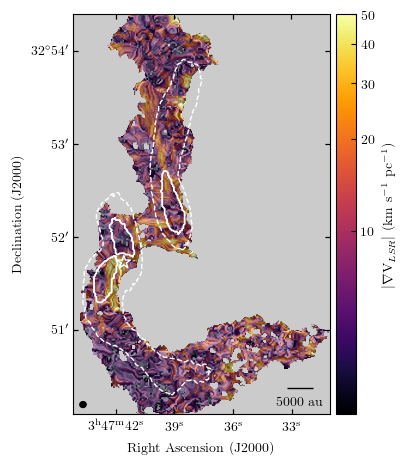

In [8]:
# With intensity as absolute value of the gradient

savefigure = True
stretch = 'linear'
cmap = copy(plt.get_cmap('inferno'))
cmap.set_bad('0.6')
vmin = 1
vmax = 50
vmid = 0.1
beams = 2.5 # width of the sampling region in beam diameters to calculate the gradient, 4 is almost the width of the filament in NH3
l_LIC = 4 # length of the streamline to visualize the gradient vectors in beam diameters

fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Nabla_intensity_{0}beams_L{1}.pdf'.format(beams, l_LIC)
vectorfile = 'B5_NOEMA_30m/gradient_LIC_{0}beams_L{1}.fits'.format(beams, l_LIC)
absfile = 'B5_NOEMA_30m/gradient_abs_{}beams.fits'.format(beams)
vector_data = fits.getdata(vectorfile)
vector_data[np.where(np.isnan(vector_data))] = 0
intdata = fits.getdata(absfile) #*vector_data
header1 = fits.getheader(absfile)
wcs = WCS(header1)
bmaj, bmin = np.array([header1['BMAJ'], header1['BMIN']]) * u.deg
bpa = header1['BPA'] * u.deg

scalebarsize = 5000
scalebardeg = (scalebarsize / dist_B5.value) / 3600 * u.deg

mapdata =  np.where(vector_data!=0, intdata, np.nan) #intdata# *vector_data #
norm = simple_norm(mapdata, 'asinh', min_cut=vmin, max_cut=vmax, asinh_a = vmid)

contdata = fits.getdata(maskcondfile)
contdata_NH3 = fits.getdata(nh3mom0file)

rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,6))
gc = fig.add_subplot(111, projection = wcs)
im = gc.imshow(mapdata, cmap=cmap, interpolation='bilinear',  norm=norm)
plt.colorbar(im, ax=gc, label=r'$|\nabla\mathrm{V}_{LSR}|$ (km s$^{-1}$ pc$^{-1}$)', shrink=0.866, pad=0.02)

gc.imshow(vector_data, interpolation='catrom', cmap='binary', alpha=0.5, vmin=0.35, vmax=0.6)
gc.contour(contdata, levels=np.array([0.5,0.8]), colors='w', linewidths=1)
gc.contour(contdata_NH3, levels=nh3mom0levels, colors='w', linestyles='dashed', transform=gc.get_transform(WCS(fits.getheader(nh3mom0file))), linewidths=1)
gc.scatter(ra_yso, dec_yso, marker='*', transform=gc.get_transform('fk5'), s=100, edgecolor='w', facecolor='none')
gc.set_xlim([65,280])
gc.set_ylim([25,360])
add_beam(gc, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.1, ec = 'k', fc='k')
gc.set_xlabel('Right Ascension (J2000)')
gc.set_ylabel('Declination (J2000)')
fontprops = fm.FontProperties(size=10)
add_scalebar(gc, scalebardeg, label=str(scalebarsize)+' au', color='k', pad=0.1, fontproperties=fontprops)

if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')

In [ ]:
# With intensity as absolute value of the gradient, in the log scale as in Chen+22

savefigure = True
stretch = 'linear'
cmap = copy(plt.get_cmap('inferno'))
cmap.set_bad('0.6')
vmin = 1
vmax = 50
vmid = 0.1
beams = 2.5 # width of the sampling region in beam diameters to calculate the gradient, 4 is almost the width of the filament in NH3
l_LIC = 4 # length of the streamline to visualize the gradient vectors in beam diameters

fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Nabla_intensity_{0}beams_L{1}_logscale.pdf'.format(beams, l_LIC)
vectorfile = 'B5_NOEMA_30m/gradient_LIC_{0}beams_L{1}.fits'.format(beams, l_LIC)
absfile = 'B5_NOEMA_30m/gradient_abs_{}beams.fits'.format(beams)
vector_data = fits.getdata(vectorfile)
vector_data[np.where(np.isnan(vector_data))] = 0
intdata = fits.getdata(absfile) #*vector_data
header1 = fits.getheader(absfile)
wcs = WCS(header1)

mapdata =  np.log10(np.where(vector_data!=0, intdata, np.nan)) #intdata# *vector_data #

contdata = fits.getdata(maskcondfile)
contdata_NH3 = fits.getdata(nh3mom0file)

rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,6))
gc = fig.add_subplot(111, projection = wcs)
im = gc.imshow(mapdata, cmap=cmap, interpolation='bilinear',  vmin=0.2, vmax=1.4)
fig.colorbar(im, ax=gc, label=r'log10 $|\nabla\mathrm{V}_{LSR}|$ (km s$^{-1}$ pc$^{-1}$)', shrink=0.866, pad=0.02)

gc.imshow(vector_data, interpolation='catrom', cmap='binary', alpha=0.5, vmin=0.35, vmax=0.6)
gc.contour(contdata, levels=np.array([0.5,0.8]), colors='w', linewidths=1)
gc.contour(contdata_NH3, levels=nh3mom0levels, colors='w', linestyles='dashed', transform=gc.get_transform(WCS(fits.getheader(nh3mom0file))), linewidths=1)
gc.scatter(ra_yso, dec_yso, marker='*', transform=gc.get_transform('fk5'), s=100,
           edgecolor='k', facecolor='none')
gc.set_xlim([65,280])
gc.set_ylim([25,360])
add_beam(gc, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.1, ec = 'k', fc='k')
gc.set_xlabel('Right Ascension (J2000)')
gc.set_ylabel('Declination (J2000)')
fontprops = fm.FontProperties(size=10)
add_scalebar(gc, scalebardeg, label=str(scalebarsize)+' au', color='k', pad=0.1, fontproperties=fontprops)


# gc.plot([245, 245+scalebarpix], [350, 350], color='k', lw=1.5)
# gc.annotate(str(scalebarsize)+' au', (0.8, 0.93), xycoords='axes fraction', color='k', size=10)

if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')

<Figure size 400x400 with 0 Axes>

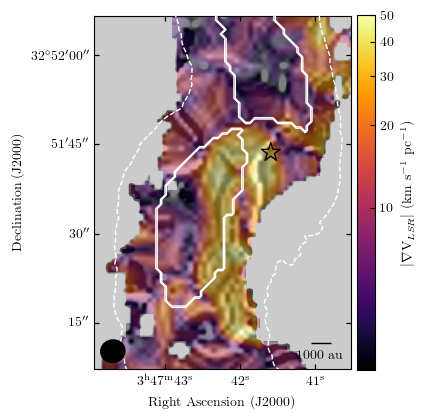

In [12]:
# With intensity as absolute value of the gradient, zoomed into the condensations

savefigure = True
stretch = 'linear'
cmap = copy(plt.get_cmap('inferno'))
cmap.set_bad('0.6')
vmin = 1
vmax = 50
vmid = 0.1
beams = 2.5 # width of the sampling region in beam diameters to calculate the gradient, 4 is almost the width of the filament in NH3
l_LIC = 4 # length of the streamline to visualize the gradient vectors in beam diameters

fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Nabla_intensity_{0}beams_L{1}_zoom_south.pdf'.format(beams, l_LIC)
vectorfile = 'B5_NOEMA_30m/gradient_LIC_{0}beams_L{1}.fits'.format(beams, l_LIC)
absfile = 'B5_NOEMA_30m/gradient_abs_{}beams.fits'.format(beams)
vector_data = fits.getdata(vectorfile)
vector_data[np.where(np.isnan(vector_data))] = 0
intdata = fits.getdata(absfile) #*vector_data
header1 = fits.getheader(absfile)
wcs = WCS(header1)
scalebarsize_s = 1000
scalebardeg_s = (scalebarsize_s / dist_B5.value) / 3600 * u.deg

mapdata =  np.where(vector_data!=0, intdata, np.nan) #intdata# *vector_data #
norm = simple_norm(mapdata, 'asinh', min_cut=vmin, max_cut=vmax, asinh_a = vmid)

contdata = fits.getdata(maskcondfile)
contdata_NH3 = fits.getdata(nh3mom0file)
filenamecontouralma = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_Tpeak.fits'
tpeak_h2coalma, tpeakheader = fits.getdata(filenamecontouralma, header=True)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,6))
gc = fig.add_subplot(111, projection = wcs)
im = gc.imshow(mapdata, cmap=cmap, interpolation='bilinear',  norm=norm)
plt.colorbar(im, ax=gc, label=r'$|\nabla\mathrm{V}_{LSR}|$ (km s$^{-1}$ pc$^{-1}$)', shrink=0.77, pad=0.02)

gc.imshow(vector_data, interpolation='catrom', cmap='binary', alpha=0.5, vmin=0.35, vmax=0.6)
gc.contour(contdata, levels=np.array([0.5,0.8]), colors='w', linewidths=1)
gc.contour(contdata_NH3, levels=nh3mom0levels, colors='w', linestyles='dashed', transform=gc.get_transform(WCS(fits.getheader(nh3mom0file))), linewidths=1)
gc.scatter(ra_yso, dec_yso, marker='*', transform=gc.get_transform('fk5'), s=200,
           edgecolor='k', facecolor='none')
gc.set_xlim([69,125])
gc.set_ylim([105,182])
add_beam(gc, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.1, ec = 'k', fc='k')
gc.set_xlabel('Right Ascension (J2000)')
gc.set_ylabel('Declination (J2000)')
fontprops = fm.FontProperties(size=10)
add_scalebar(gc, scalebardeg_s, label=str(scalebarsize_s)+' au', color='k', pad=0.1, fontproperties=fontprops)

# gc.plot([245, 245+scalebarpix], [350, 350], color='k', lw=1.5)
# gc.annotate(str(scalebarsize)+' au', (0.8, 0.93), xycoords='axes fraction', color='k', size=10)

if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')

In [ ]:
# With intensity as absolute value of the gradient, zoomed into the condensations

savefigure = True
stretch = 'linear'
cmap = copy(plt.get_cmap('inferno'))
cmap.set_bad('0.6')
vmin = 1
vmax = 50
vmid = 0.1
beams = 2.5 # width of the sampling region in beam diameters to calculate the gradient, 4 is almost the width of the filament in NH3
l_LIC = 4 # length of the streamline to visualize the gradient vectors in beam diameters

fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Nabla_intensity_{0}beams_L{1}_zoom_north.pdf'.format(beams, l_LIC)
vectorfile = 'B5_NOEMA_30m/gradient_LIC_{0}beams_L{1}.fits'.format(beams, l_LIC)
absfile = 'B5_NOEMA_30m/gradient_abs_{}beams.fits'.format(beams)
vector_data = fits.getdata(vectorfile)
vector_data[np.where(np.isnan(vector_data))] = 0
intdata = fits.getdata(absfile) #*vector_data
header1 = fits.getheader(absfile)
wcs = WCS(header1)


mapdata =  np.where(vector_data!=0, intdata, np.nan) #intdata# *vector_data #
norm = simple_norm(mapdata, 'asinh', min_cut=vmin, max_cut=vmax, asinh_a = vmid)

contdata = fits.getdata(maskcondfile)
contdata_NH3 = fits.getdata(nh3mom0file)

rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,6))
gc = fig.add_subplot(111, projection = wcs)
im = gc.imshow(mapdata, cmap=cmap, interpolation='bilinear',  norm=norm)
plt.colorbar(im, ax=gc, label=r'$|\nabla\mathrm{V}_{LSR}|$ (km s$^{-1}$ pc$^{-1}$)', shrink=0.94,  pad=0.02) #, shrink=0.9)

gc.imshow(vector_data, interpolation='catrom', cmap='binary', alpha=0.5, vmin=0.35, vmax=0.6)
gc.contour(contdata, levels=np.array([0.5,0.8]), colors='w', linewidths=1)
gc.contour(contdata_NH3, levels=nh3mom0levels, colors='w', linestyles='dashed', transform=gc.get_transform(WCS(fits.getheader(nh3mom0file))), linewidths=1)
gc.scatter(ra_yso, dec_yso, marker='*', transform=gc.get_transform('fk5'), s=200,
           edgecolor='k', facecolor='none')
gc.set_xlim([116,172])
gc.set_ylim([167, 260])
add_beam(gc, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.1, ec = 'k', fc='k')
add_scalebar(gc, scalebardeg_s, label=str(scalebarsize_s)+' au', color='k', pad=0.1, fontproperties=fontprops)
gc.set_xlabel('Right Ascension (J2000)')
gc.set_ylabel('Declination (J2000)')
fontprops = fm.FontProperties(size=10)


# gc.plot([245, 245+scalebarpix], [350, 350], color='k', lw=1.5)
# gc.annotate(str(scalebarsize)+' au', (0.8, 0.93), xycoords='axes fraction', color='k', size=10)

if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')

<Figure size 400x400 with 0 Axes>

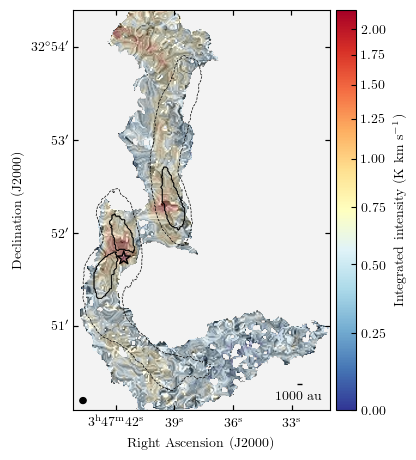

In [10]:
# With intensity as integrated intensity map
savefigure = True

stretch = 'arcsinh'
cmapl = 'RdYlBu_r'
vmin = 0.
vmax = 2.2
vmid = 0.3
beams = 2.5# width of the sampling region in beam diameters to calculate the gradient, 4 is almost the width of the filament in NH3
l_LIC = 4 # length of the streamline to visualize the gradient vectors in beam diameters

cmap = copy(cm.get_cmap(cmapl))
cmap.set_bad('0.85')

fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Nabla_Vlsr_int_intensity_{0}beams_L{1}.pdf'.format(beams, l_LIC)
vectorfile = 'B5_NOEMA_30m/gradient_LIC_{0}beams_L{1}.fits'.format(beams, l_LIC)
absfile = mom0file
# absfile = 'B5_NOEMA_30m/gradient_abs_{}beams.fits'.format(beams)
vector_data = fits.getdata(vectorfile)
# vector_data = (vector_data - np.nanmean(vector_data))/np.nanstd(vector_data)
vector_data /= np.nanmax(vector_data)
vector_data[np.where(np.isnan(vector_data))] = 0
intdata = fits.getdata(absfile) #*vector_data
header1 = fits.getheader(absfile)
wcs = WCS(header1)

mapdata =  np.where(vector_data!=0, intdata, np.nan) #intdata# *vector_data #

norm = simple_norm(mapdata, 'asinh', min_cut=vmin, max_cut=vmax, asinh_a = vmid)
# norm = ImageNormalize(mapdata, vmin=vmin, vmax=vmax,
#                       stretch=AsinhStretch(a=0.8))

contdata = fits.getdata(maskcondfile)
contdata_NH3 = fits.getdata(nh3mom0file)

rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,6))
gc = fig.add_subplot(111, projection = wcs)
im = gc.imshow(mapdata, cmap=cmap, interpolation='bilinear', norm=norm)
plt.colorbar(im, ax=gc, label=r'Integrated intensity (K km s$^{-1}$)', shrink=0.866, pad=0.02)
# gc = plot_aplpy_subfig(fits.PrimaryHDU(mapdata, header1), fig, (1,1,1), stretch, \
#                             vmin, vmax, cmap, vmid=vmid)

gc.imshow(vector_data, interpolation='catrom', cmap='binary', alpha=0.7, vmin=0.35, vmax=0.75)
gc.contour(contdata, levels=np.array([0.5,0.8]), colors='k', linewidths=0.5)
gc.contour(contdata_NH3, levels=nh3mom0levels, colors='k', linestyles='dashed', transform=gc.get_transform(WCS(fits.getheader(nh3mom0file))), linewidths=0.5)
gc.scatter(ra_yso, dec_yso, marker='*', transform=gc.get_transform('fk5'), s=100,
           edgecolor='k', facecolor='none')
gc.set_xlim([65,280])
gc.set_ylim([25,360])
add_beam(gc, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.1, ec = 'k', fc='k')
add_scalebar(gc, scalebardeg_s, label=str(scalebarsize_s)+' au', color='k', pad=0.1, fontproperties=fontprops)
gc.set_xlabel('Right Ascension (J2000)')
gc.set_ylabel('Declination (J2000)')

if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')

<Figure size 400x400 with 0 Axes>

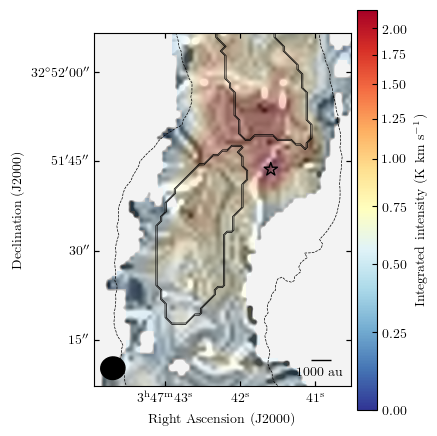

In [13]:
# With intensity as integrated intensity map, zoomed into the south filament
savefigure = True

stretch = 'arcsinh'
cmapl = 'RdYlBu_r'
vmin = 0.
vmax = 2.2
vmid = 0.3
beams = 2.5# width of the sampling region in beam diameters to calculate the gradient, 4 is almost the width of the filament in NH3
l_LIC = 4 # length of the streamline to visualize the gradient vectors in beam diameters

cmap = copy(cm.get_cmap(cmapl))
cmap.set_bad('0.85')

fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Nabla_Vlsr_int_intensity_{0}beams_L{1}_zoom_south.pdf'.format(beams, l_LIC)
vectorfile = 'B5_NOEMA_30m/gradient_LIC_{0}beams_L{1}.fits'.format(beams, l_LIC)
absfile = mom0file
# absfile = 'B5_NOEMA_30m/gradient_abs_{}beams.fits'.format(beams)
vector_data = fits.getdata(vectorfile)
# vector_data = (vector_data - np.nanmean(vector_data))/np.nanstd(vector_data)
vector_data /= np.nanmax(vector_data)
vector_data[np.where(np.isnan(vector_data))] = 0
intdata = fits.getdata(absfile) #*vector_data
header1 = fits.getheader(absfile)
wcs = WCS(header1)

mapdata =  np.where(vector_data!=0, intdata, np.nan) #intdata# *vector_data #

norm = simple_norm(mapdata, 'asinh', min_cut=vmin, max_cut=vmax, asinh_a = vmid)
# norm = ImageNormalize(mapdata, vmin=vmin, vmax=vmax,
#                       stretch=AsinhStretch(a=0.8))

contdata = fits.getdata(maskcondfile)
contdata_NH3 = fits.getdata(nh3mom0file)

rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,6))
gc = fig.add_subplot(111, projection = wcs)
im = gc.imshow(mapdata, cmap=cmap, interpolation='bilinear', norm=norm)
plt.colorbar(im, ax=gc, label=r'Integrated intensity (K km s$^{-1}$)', shrink=0.866, pad=0.02)
# gc = plot_aplpy_subfig(fits.PrimaryHDU(mapdata, header1), fig, (1,1,1), stretch, \
#                             vmin, vmax, cmap, vmid=vmid)

gc.imshow(vector_data, interpolation='catrom', cmap='binary', alpha=0.7, vmin=0.35, vmax=0.75)
gc.contour(contdata, levels=np.array([0.5,0.8]), colors='k', linewidths=0.5)
gc.contour(contdata_NH3, levels=nh3mom0levels, colors='k', linestyles='dashed', transform=gc.get_transform(WCS(fits.getheader(nh3mom0file))), linewidths=0.5)
gc.scatter(ra_yso, dec_yso, marker='*', transform=gc.get_transform('fk5'), s=100,
           edgecolor='k', facecolor='none')
gc.set_xlim([69,125])
gc.set_ylim([105,182])
add_beam(gc, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.1, ec = 'k', fc='k')
add_scalebar(gc, scalebardeg_s, label=str(scalebarsize_s)+' au', color='k', pad=0.1, fontproperties=fontprops)
gc.set_xlabel('Right Ascension (J2000)')
gc.set_ylabel('Declination (J2000)')

if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')

<Figure size 400x400 with 0 Axes>

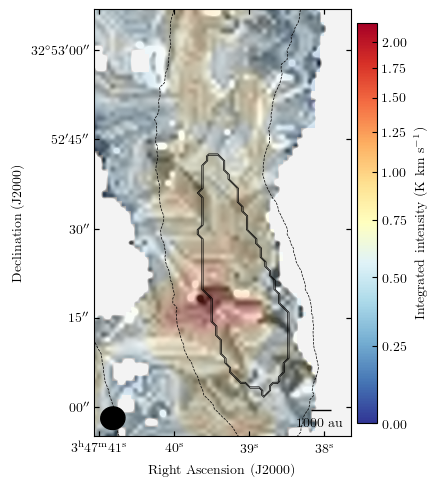

In [14]:
# With intensity as integrated intensity map, zoomed into the north filament
savefigure = True

stretch = 'arcsinh'
cmapl = 'RdYlBu_r'
vmin = 0.
vmax = 2.2
vmid = 0.3
beams = 2.5# width of the sampling region in beam diameters to calculate the gradient, 4 is almost the width of the filament in NH3
l_LIC = 4 # length of the streamline to visualize the gradient vectors in beam diameters

cmap = copy(cm.get_cmap(cmapl))
cmap.set_bad('0.85')

fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Nabla_Vlsr_int_intensity_{0}beams_L{1}_zoom_north.pdf'.format(beams, l_LIC)
vectorfile = 'B5_NOEMA_30m/gradient_LIC_{0}beams_L{1}.fits'.format(beams, l_LIC)
absfile = mom0file
# absfile = 'B5_NOEMA_30m/gradient_abs_{}beams.fits'.format(beams)
vector_data = fits.getdata(vectorfile)
# vector_data = (vector_data - np.nanmean(vector_data))/np.nanstd(vector_data)
vector_data /= np.nanmax(vector_data)
vector_data[np.where(np.isnan(vector_data))] = 0
intdata = fits.getdata(absfile) #*vector_data
header1 = fits.getheader(absfile)
wcs = WCS(header1)

mapdata =  np.where(vector_data!=0, intdata, np.nan) #intdata# *vector_data #

norm = simple_norm(mapdata, 'asinh', min_cut=vmin, max_cut=vmax, asinh_a = vmid)
# norm = ImageNormalize(mapdata, vmin=vmin, vmax=vmax,
#                       stretch=AsinhStretch(a=0.8))

contdata = fits.getdata(maskcondfile)
contdata_NH3 = fits.getdata(nh3mom0file)

rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,6))
gc = fig.add_subplot(111, projection = wcs)
im = gc.imshow(mapdata, cmap=cmap, interpolation='bilinear', norm=norm)
plt.colorbar(im, ax=gc, label=r'Integrated intensity (K km s$^{-1}$)', shrink=0.866, pad=0.02)
# gc = plot_aplpy_subfig(fits.PrimaryHDU(mapdata, header1), fig, (1,1,1), stretch, \
#                             vmin, vmax, cmap, vmid=vmid)

gc.imshow(vector_data, interpolation='catrom', cmap='binary', alpha=0.7, vmin=0.35, vmax=0.75)
gc.contour(contdata, levels=np.array([0.5,0.8]), colors='k', linewidths=0.5)
gc.contour(contdata_NH3, levels=nh3mom0levels, colors='k', linestyles='dashed', transform=gc.get_transform(WCS(fits.getheader(nh3mom0file))), linewidths=0.5)
gc.scatter(ra_yso, dec_yso, marker='*', transform=gc.get_transform('fk5'), s=100,
           edgecolor='k', facecolor='none')
gc.set_xlim([116,172])
gc.set_ylim([167, 260])
add_beam(gc, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.1, ec = 'k', fc='k')
add_scalebar(gc, scalebardeg_s, label=str(scalebarsize_s)+' au', color='k', pad=0.1, fontproperties=fontprops)
gc.set_xlabel('Right Ascension (J2000)')
gc.set_ylabel('Declination (J2000)')

if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')

### Results of the 2 Gaussian fit to HC$_3$N ($10-9$)

#### Spectrum at IRS1 after 2 Gaussian fit

In [ ]:
# fit results in B5-IRS1
savefigure = True
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectrum_B5IRS1_wfit2G_1G_wres.pdf'

# positionfile = 'B5_NOEMA_30m/figures/B5_IRS1.reg'
# positions, labels = getPositionFromRegions(positionfile)
cube_HC3Ns = SpectralCube.read(smallimagefile+'.fits').with_spectral_unit(u.km/u.s)
paramsfile2g = fitfile2filtered
paramscube2g = fits.getdata(paramsfile2g)
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectrum_B5IRS1_wfit2G.pdf'

params = get_parameters_spectra(paramscube, position_IRS1, cube_HC3N.header)
g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
params2g = get_parameters_spectra(paramscube2g, position_IRS1, cube_HC3Ns.header)
g1s = Gaussian1D(amplitude=params2g[0], mean=params2g[1], stddev=params2g[2])
g2s = Gaussian1D(amplitude=params2g[3], mean=params2g[4], stddev=params2g[5])
vels = np.arange(velinit.value, velend.value, step=0.01)

fig, [ax, ax2] = plt.subplots(2, 1, figsize=(4,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax2.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
ax2.set_ylabel('S/N residual')
spectrum = get_spectra(cube_HC3N, position_IRS1, velinit, velend)
spectrums = get_spectra(cube_HC3Ns, position_IRS1, velinit, velend)
ax.plot(spectrums[0], spectrums[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vels, g1s(vels), color='k', label=r'2G comp. 1')
ax.plot(vels, g2s(vels), color='r', label=r'2G comp. 2')

ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'1G', alpha=0.5)
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted')
ax.legend(fontsize=8, frameon=False)
ax2.axhline(-3, linestyle='dotted')
ax2.axhline(3, linestyle='dotted')
ax.annotate(r'$V_{LSR}$ IRS1', (0.48, 0.2), xycoords='axes fraction', size=8, rotation=90)

ax2.plot(spectrums[0], (spectrums[1].value - (g1s(spectrums[0].value)+g2s(spectrums[0].value)))/rmsKkmsHC3N, drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax2.plot(spectrum[0], (spectrum[1].value - (g1(spectrum[0].value)))/rmsKkmsHC3N, drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)', linestyle='dashed')
ax2.set_ylim([-5, 5])
ax2.annotate(r'S/N$=3$', (0.8, 0.85), xycoords='axes fraction', size=8)
fig.subplots_adjust(hspace=0)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

#### Maps of the components

In [ ]:
# strongest component
savefigure = True

fig = plt.figure(1, figsize=(16,8))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams_filtered_resultscomp1.pdf'
# paramsfile2g = fitfile2filtered
# paramscube2g = fits.getdata(paramsfile2g)
cube_2g = fits.getdata(fitfile2filtered)
paramscube_2g = cube_2g[:3]

momentsmall = cube_HC3Ns.moment()
headerplot = momentsmall.header
stretch = 'linear'
vmin = [0, 9.9, 0]
vmax = [np.round(np.nanmax(paramscube_2g[0]), 1), 10.5, np.round(np.nanmax(paramscube_2g[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$', r'$V_{LSR}$', r'$\sigma_{\mathrm{r}}$']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube_2g[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i], barsize=1000)
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9234601, 32.8620242, 0.0030777)
    ax0.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)

    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
    elif not i:
        ax0.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
        
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

In [ ]:
# Weakest component
savefigure = True
fig = plt.figure(1, figsize=(16,8))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams_filtered_resultscomp2.pdf'

paramscube_2g = cube_2g[3:6]
headerplot = momentsmall.header
stretch = 'linear'
vmin = [0, 9.0, 0]
vmax = [np.round(np.nanmax(paramscube_2g[0]), 1), 10.5, np.round(np.nanmax(paramscube_2g[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$', r'$V_{LSR}$', r'$\sigma_{\mathrm{r}}$']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube_2g[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i], barsize=1000)
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9234601, 32.8620242, 0.0030777)
    ax0.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)
    
    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
    elif not i:
        ax0.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
        
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

In [ ]:
# probability map and streamer location
saveaction = True
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_probability_wstreamer.pdf'

probdata = fits.getdata(fitfile2filtered_probfile)
maskdata, maskhead = fits.getdata(fitfile2filtered_maskfile, header=True)
plotdata = np.where(maskdata, probdata, np.nan)
maskhead['BMAJ'] = 1.132421500229E-03 
maskhead['BMIN'] = 1.052162182519E-03
maskhead['BPA'] = -8.140348361243E+01

filenamecontour = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_Tpeak.fits'
tpeak_h2coalma, tpeakheader = fits.getdata(filenamecontour, header=True)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(fits.PrimaryHDU(plotdata, maskhead), fig, (1,1,1), 'linear', 0, 0.5, 'viridis', barsize=1000)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)
gc.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=1)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.beam.set_facecolor('None')

if saveaction:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

### Line ratio maps and column density

In [ ]:
# line ratio with KDE as inset
savefigure = False
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5_NOEMA_30m_10-9_over_8-7_wregions_KDEinset.pdf'
data, dens, median_unc = np.load(ratiomapkdefile, allow_pickle=True)
regions_mass = filedir + 'filaments_mass_area.reg'

gc = plot_aplpy_subfig(ratiomapfile, fig, (1,1,1), 'linear', 0, 1.5, 'inferno')

# filament outline from NH3(1,1)
gc.show_contour(maskC1file, colors='w', linewidths=1)
gc.show_contour(maskC2file, colors='w', linewidths=1)
gc.show_contour(maskC3file, colors='w', linewidths=1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
gc.add_label(0.1, 0.75, 'Fil-1', relative=True, color='k', size=12)
gc.add_label(0.45, 0.25, 'Fil-2', relative=True, color='k', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.colorbar.set_axis_label_text(r'$R_{\frac{10-9}{8-7}}$')
gc.colorbar.set_ticks([0,0.15,0.3,0.45, 0.6,0.75, 0.9,1.05, 1.2,1.35, 1.5])
gc.colorbar.set_pad(0.1)
gc.scalebar.set_corner('top left')
gc.scalebar.set_label('5000 au')
gc.show_regions(regions_mass)
gc.set_nan_color('0.6')

insetax = fig.add_axes([0.53,0.44,0.22,0.3])
insetax.plot(data, dens, color=colorHC3N)
insetax.plot([median_unc[1], median_unc[1]], [0, 1], color=colorHC3N, ls='--')
insetax.text(median_unc[1]-0.12,2.55,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(median_unc[1], median_unc[0]-median_unc[1], median_unc[2]-median_unc[1]), size=12, color=colorHC3N)
# insetax.set_xlabel(r'$R_{\frac{10-9}{8-7}}$)')
# ax.set_ylabel('Density')
insetax.set_xlim([0, 1.5])
insetax.set_ylim([0, 3])
insetax.set_xlabel(r'$R_{\frac{10-9}{8-7}}$')
insetax.set_xticks([0, 0.5, 1, 1.5])
insetax.set_ylim(bottom=0)
#

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

In [ ]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5_NOEMA_30m_10-9_Ntot_noreg.pdf'
regions_mass = filedir + 'filaments_mass_area.reg'

gc = plot_aplpy_subfig(Ntotmapfile, fig, (1,1,1), 'linear', 1e12, 6e13, 'viridis', showframeScalebar=True)

# filament outline from NH3(1,1)
gc.show_contour(maskC1file, colors='w', linewidths=1)
gc.show_contour(maskC2file, colors='w', linewidths=1)
gc.show_contour(maskC3file, colors='w', linewidths=1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
# gc.add_label(0.6, 0.75, 'Fil-1', relative=True, color='k', size=12)
# gc.add_label(0.45, 0.25, 'Fil-2', relative=True, color='k', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.colorbar.set_axis_label_text(r'HC$_3$N Column density (cm$^{-2}$)')
# if you want to add the regions where we add up the column density
# gc.show_regions(regions_mass)

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

### Flow of mass: gradient times the column density

In [ ]:
savefigure =True
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5_NOEMA_30m_10-9_Ntot_times_grad.pdf'
mapfile = filedir + 'mass_flow_NHC3N_gradient_abs_2.5beams.fits'

intmap, intheader = fits.getdata(mapfile, header=True)
logmap = np.log10(intmap)

gc = plot_aplpy_subfig(fits.PrimaryHDU(logmap,intheader), fig, (1,1,1), 'linear', 14, 15.2, 'magma', showframeScalebar=True)

# filament outline from NH3(1,1)
gc.show_contour(maskC1file, colors='w', linewidths=1)
gc.show_contour(maskC2file, colors='w', linewidths=1)
gc.show_contour(maskC3file, colors='w', linewidths=1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
# gc.add_label(0.6, 0.75, 'Fil-1', relative=True, color='k', size=12)
# gc.add_label(0.45, 0.25, 'Fil-2', relative=True, color='k', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.colorbar.set_axis_label_text(r'log$_{10}$ $(|\nabla\mathrm{V}_{LSR}| \times N(HC_3N))$ (cm$^{-2}$km s$^{-1}$ pc$^{-1}$)')
# if you want to add the regions where we add up the column density
# gc.show_regions(regions_mass)


if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

## ALMA observations: H$_2$CO and C$^{18}$O

### Filenames

In [ ]:
filediralma = 'B5_IRS1_ALMA/'
# H2CO data cubes
h2cocubefile = filediralma + 'data/B5IRS1_H2COa_robust05_multi_3_cut_pbcor.fits'
h2cocubefileK = filediralma + 'data/B5IRS1_H2COa_robust05_multi_3_cut_pbcor_K_contcorrected.fits'
h2comom0file = filediralma + 'data/B5IRS1_H2COa_robust05_multi_3_cut_mom0.fits'
h2comom0bluefile = filediralma + 'data/B5IRS1_H2COa_robust05_multi_3_cut_mom0_blueenv.fits'
# h2comom1file = filediralma + 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_mom1.fits'
rms_mom0_h2co = 0.005714 # Jy/b km/s
figurefolder = 'figures/'
freq_H2CO = 218.222195 * u.GHz
regions_alma_spectra = filediralma + 'region_plot_H2CO_4.reg'

# Filenames: resulting components of 1, 2, and 3 Gaussian fit to H2CO, both masked and not masked combined
h2cofitfile1G = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_total_aicres.fits'
h2cofitfile2G = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_2G_fitparams_total_aicres.fits'
h2cofitfile3G = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_3G_fitparams_total_aicres.fits'
h2cofitparamsmissing = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_paramsmissing.fits'
h2concomponentfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_total_ncomponents.fits'

h2cofitfile1G_allchans = filediralma + 'gaussfit_H2CO/all_chans/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_2_filtered_Vlsr'

# DBSCAN results
dbscanresfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/DBSCAN_results.csv'
h2cotpeakbluefile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_Tpeak.fits'
h2cotpeakredfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_Tpeak.fits'
h2coblueparamsfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope.fits'
h2cobluevlsrfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_vlsr.fits'
h2coredparamsfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope.fits'
h2coredvlsrfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_vlsr.fits'
spine_coordinates_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_spine_coords_vel.npy'
kde_blue_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_kde.npy'
kde_blue_sigma_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_kde_sigma_nt.npy'
kde_red_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_kde.npy'
kde_red_sigma_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_kde_sigma_nt.npy'
sl_model_blue_init_result_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_sl_model_res.npy'
sl_model_red_init_result_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_sl_model_res.npy'
sl_tinymodel_red_init_result_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_sl_tinymodel_res.npy'


# C18O datacubes
c18ocubefile = filediralma + 'data/B5IRS1_C18O_robust05_multi_cut.fits'
c18ocubefileK = filediralma + 'data/B5IRS1_C18O_robust05_multi_cut_K.fits'
c18omom0file = filediralma + 'data/B5IRS1_C18O_robust05_multi_mom0.fits'
c18omom1file = filediralma + 'data/B5IRS1_C18O_robust05_multi_mom1.fits'
c18opvdiagramfile = filediralma + 'data/B5IRS1_C18O_robust05_multi_K_PV_157.1 degdeg_12arcsec_0.44width_cont_centered.fits'
regions_alma_C18O_spectra = filediralma + 'region_plot_C18O.reg'
rms_mom0_c18o = 0.007 # Jy/b km/s
freq_C18O = 219.560354 * u.GHz
# C18O gaussian fit results
c18opositionbluefile = filediralma + 'positions_displacement_arcsec_blue.npy'
c18opositionredfile = filediralma + 'positions_displacement_arcsec_red.npy'
c18odistancebluefile = filediralma + 'distances_displacement_au_blue.npy'
c18odistanceredfile = filediralma + 'distances_displacement_au_red.npy'

### Moment 0 Maps of H$_2$CO ($3_{0, 3} - 2_{0, 2}$)

In [ ]:
# moment 0 with inferno for streamer gallery
savefigure = True
title = r'\textbf{H\boldmath$_2$CO($3_{0,3}-2_{0,2}$)}'
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_cut_mom0_blueenv_inferno_wzoom.pdf'
gc = plot_aplpy_subfig(h2comom0bluefile, fig, (1,1,1), 'arcsinh', 0, 7.5, 'inferno', vmid=3, label_col='w',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='w', edgecolor='k', s=100)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_H2CO)/2).to(u.deg).value, color='w')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.add_label(0.62,0.9, title, color='w',
              relative=True, horizontalalignment='right', 
              size=14)
gc.colorbar.set_pad(0.1)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

In [ ]:
# moment 0 and outflow
savefigure = True

fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_cut_mom0_woutflow.pdf' #_regions
gc = plot_aplpy_subfig(h2comom0file, fig, (1,1,1), 'arcsinh', 0, 0.1, 'viridis', vmid=0.05, label_col='w',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_H2CO)/2).to(u.deg).value, color='w')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')
# gc.show_regions(regions_alma_spectra)

arrowlength = 0.0005
pa = (157.1-180) * 180/ np.pi

gc.show_arrows(ra_yso+0.0001, dec_yso+0.00005,arrowlength*np.sin(pa), arrowlength*np.cos(pa), color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.00005,arrowlength*np.sin(pa), arrowlength*np.cos(pa), color='b', zorder=100)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.00005, -arrowlength*np.sin(pa), -arrowlength*np.cos(pa), color='w', linewidth=3)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.00005, -arrowlength*np.sin(pa), -arrowlength*np.cos(pa), color='r', zorder=100)
gc.colorbar.set_pad(0.1)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

### Channel maps of H$_2$CO ($3_{0, 3} - 2_{0, 2}$)

In [ ]:
cube_H2CO = SpectralCube.read(h2cocubefileK).with_spectral_unit(u.km/u.s)
wcssky = WCS(cube_H2CO.header).celestial    
ra_yso_pix, dec_yso_pix = wcssky.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)
pbradius = (primary_beam_alma(freq_H2CO)/2).to(u.deg).value / cube_H2CO.header['CDELT2']
colorH2CO = '#377eb8' #blue

In [ ]:
savefigure = True

velinit = 8.45 * u.km/u.s
deltav = 0.25 * u.km/u.s
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 4
ncols = 4
vmax = 12
vmin = 0
velocity_array = cube_H2CO.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 
bmaj, bmin = np.array([cube_H2CO.header['BMAJ'], cube_H2CO.header['BMIN']]) #/np.abs(cube_H2CO.header['CDELT2'])
bpa = cube_H2CO.header['BPA']
scalebarsize = 500 #au
scalebardeg = (scalebarsize / dist_B5.value) * u.arcsec
fontprops = fm.FontProperties(size=6)

fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = cube_H2CO.unmasked_data[indexvel, :, :]
    im = ax.imshow(planevel, vmin = vmin, vmax=vmax)
    labelvel = '{:.2f}'.format(velocity_sample[i])
    ax.annotate(labelvel+ r' km s$^{-1}$', (0.3, 0.85), xycoords='axes fraction', color='w', size=6)
    add_beam(ax, major=bmaj*u.deg, minor=bmin*u.deg, angle=bpa*u.deg, frame=False, pad=0.1, ec = 'w', fc='w')
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=15, linewidth=0.5, alpha=0.8)
    
    if i == 0:
        pb = Circle((ra_yso_pix, dec_yso_pix), pbradius, ec = 'w', fc='None', ls=':')
        ax.add_patch(pb)
        ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=15, linewidth=0.5, alpha=0.8) 
        
        
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=6)
        lat.set_axislabel('Declination (FK5, J2000)', size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)
        lat.set_ticklabel(size=6)
        add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='w', pad=0.1, fontproperties=fontprops)
        
fig.tight_layout()
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.5)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.36])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,2,4,6,8,10,12])
cbar.set_label(label=r'$T_{MB}$ (K)', size=8)
cbar_ax.set_yticklabels(['0', '2', '4', '6', '8', '10', '12'])
cbar_ax.tick_params(labelsize=6) 

if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')
    

### Spectra of selected regions for H$_2$CO ($3_{0, 3} - 2_{0, 2}$)

In [ ]:
#spectra at the location of the protostar

savefig = True

velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'B5-IRS1 \\ H$_2$CO ($3_{0,3} - 2_{0,2}$)'
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_spectra_IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cube_H2CO, position_IRS1, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorH2CO)
ax.text(0.02, 0.9, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

### Results of the multi-Gaussian fit to H$_2$CO ($3_{0, 3} - 2_{0, 2}$)

In [ ]:
# plot the number of components 

savefigure = False
figname = figurefolder + 'B5IRS1_H2COa_total_aicres_ncomponents.pdf'

data = fits.getdata(h2concomponentfile)
data[np.where(np.isnan(data))] = 0
header = fits.getheader(h2concomponentfile)
wcs = WCS(header)
bmaj, bmin = np.array([header['BMAJ'], header['BMIN']]) * u.deg
bpa = header['BPA'] *u.deg
scalebarsize = 500 #au
scalebardeg = (scalebarsize / dist_B5.value) * u.arcsec
fontprops = fm.FontProperties(size=10)

cmap1 = copy( plt.cm.get_cmap("YlGnBu", 4))
rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection=wcs)
sc1 = ax.imshow(data, cmap=cmap1, vmin=-0.5, vmax=3.5) # red
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4), pad=0)
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.3, ec = 'k', fc='k')
ax.scatter(rapix, decpix, marker='*', s=100, facecolor='none', edgecolor='k', linewidth=2)

ax.set_xlim([45,230])
ax.set_ylim([32,232])
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')

add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='k', pad=0.1, fontproperties=fontprops)

positionsspec, labelsspec = getPositionFromRegions(regions_alma_spectra)
positions_2 = wcssky.all_world2pix(positionsspec, 0)
ax.scatter(positions_2[:,0], positions_2[:,1], s=15, marker='o', facecolor='None', edgecolor='k')
for i in range(len(labelsspec)):
    ax.annotate(labelsspec[i], xy=(positions_2[i,0], positions_2[i,1]), xytext=(positions_2[i,0]-1, 140-80  if i%2 else 140+75), size=12,  arrowprops=dict(arrowstyle="->", linewidth=0.5))
    #bbox=dict(boxstyle="round", fc="w"),

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

In [ ]:
#spectra at selected locations in the streamer and pseudodisk
# needs the previous code to run
savefig = False

ncompmap = fits.getdata(h2concomponentfile)
header = fits.getheader(h2concomponentfile)
wcs = WCS(header)
h2coparams1g = fits.getdata(h2cofitfile1G)
h2coparams2g = fits.getdata(h2cofitfile2G)
h2coparams3g = fits.getdata(h2cofitfile3G)

positions, labels = getPositionFromRegions(regions_alma_spectra)
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'H$_2$CO ($3_{0,3} - 2_{0,2}$)'
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_spectra_selected_regions.pdf'
vel = np.arange(velinit.value, velend.value, step=0.01)

fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(8,4))
axes = axes.flatten()
axes[3].set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
axes[3].set_ylabel(r'$T_{MB}$ (K)')

for i in range(len(axes)):
    position = positions[i]
    posx, posy = np.round(wcs.wcs_world2pix(position[0], position[1], 0))
    ncomps = ncompmap[int(posy), int(posx)]

    if ncomps == 1: 
        params = get_parameters_spectra(h2coparams1g, position, cube_H2CO.header)
        g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
    elif ncomps == 2:
        params = get_parameters_spectra(h2coparams2g, position, cube_H2CO.header)
        g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2]) + Gaussian1D(amplitude=params[3], mean=params[4], stddev=params[5])
        comp1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
        comp2 = Gaussian1D(amplitude=params[3], mean=params[4], stddev=params[5])
    elif ncomps == 3:
        params = get_parameters_spectra(h2coparams3g, position, cube_H2CO.header)
        g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2]) + Gaussian1D(amplitude=params[3], mean=params[4], stddev=params[5]) + Gaussian1D(amplitude=params[6], mean=params[7], stddev=params[8])
        comp1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2]) 
        comp2 = Gaussian1D(amplitude=params[3], mean=params[4], stddev=params[5]) 
        comp3 = Gaussian1D(amplitude=params[6], mean=params[7], stddev=params[8])

    spectrum = get_spectra(cube_H2CO, position, velinit, velend)
    
    ax = axes[i]
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorH2CO, label=label)
    if not labels[i] == 'B5-IRS1':
        ax.plot(vel, g1(vel), color='k', label='Best fit model')
        if ncomps > 1: 
            ax.plot(vel, comp1(vel), color='r', ls='dashed', label='Comp. 1')
            ax.plot(vel, comp2(vel), color='b', ls='dashed', label='Comp. 2')
            if ncomps == 3: ax.plot(vel, comp3(vel), color='g', ls='dashed', label='Comp. 3')
    
    ax.text(0.9, 0.9, labels[i], horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.2, color='k', linestyle='dotted') #, label=r'$V_{LSR}$ IRS1 (NH$_3$)')
    if i==3: ax.tick_params(axis='y', which='both', left=False)
    if i in [3,5] or labels[i]=='B5-IRS1': ax.axvspan(9.7, 10.3, color='k', alpha=0.2)
    
# ax = axes[5]
# posx, posy = np.round(wcs.wcs_world2pix(position_IRS1[0], position_IRS1[1], 0))
# ncomps = ncompmap[int(posy), int(posx)]
# spectrum = get_spectra(cube_H2CO, position_IRS1, velinit, velend)

# ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorH2CO)

# ax.axvspan(9.7, 10.3, color='k', alpha=0.2)
# ax.text(0.5, 0.9, 'B5-IRS1', horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
fig.subplots_adjust(wspace=0.02, hspace=0)
# axes[0].text(0.02, 0.85, label, horizontalalignment='left', transform=axes[0].transAxes, color='k', size=10)
handles, labels = axes[2].get_legend_handles_labels()
axes[0].legend(handles, labels, loc=(0.01, 0.55), fontsize=6, frameon=False)
if savefig:
    fig.savefig(figname, bbox_inches='tight', dpi=dpibase)

In [ ]:
# AIC evaluated 1 Gaussian fit v_lsr (to compare with HC3N and NH3)

savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_1G_fitparams_total_aicres_Vlsr'

cube1g = fits.getdata(h2cofitfile1G)
paramscube1g = cube1g[1]
header = fits.getheader(h2cofitparamsmissing)
stretch = 'linear'
vmin = 10.2-0.5
vmax = 10.2+0.5
cmap = 'RdYlBu_r'
quantities = r'V$_{LSR}$ (km s$^{-1}$)'

data = paramscube1g
# header = fits.getheader(h2concomponentfile)
wcs = WCS(header)
bmaj, bmin = np.array([header['BMAJ'], header['BMIN']]) * u.deg
bpa = header['BPA'] * u.deg

cmap1 = plt.cm.get_cmap(cmap).copy()
cmap1.set_bad(color='0.85')
rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection=wcs)
sc1 = ax.imshow(data, cmap=cmap1, vmin=vmin, vmax=vmax) # red
cax = plt.colorbar(sc1, ax=ax, label=quantities,extend='both')
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.3, ec = 'k', fc='k')
ax.scatter(rapix, decpix, marker='*', s=100, facecolor='none', edgecolor='k', linewidth=2)

ax.set_xlim([45,230])
ax.set_ylim([32,232])
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')
ax.annotate(r'ALMA H$_2$CO ($3_{0,3}-2_{0,2}$)', (0.05, 0.9), xycoords='axes fraction',color='k', size=10)

if savefigure:
    fig.savefig(figname+'.pdf', bbox_inches='tight', dpi=dpibase)
    

### Results of the clustering of multi-Gaussian fit

#### Visualization of DBSCAN results

In [ ]:
# test to plot the v_lsr together
savefigure = False
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_envelopes_vlsr.pdf'

data1 = fits.getdata(h2coredvlsrfile)
header1 = fits.getheader(h2coredvlsrfile)
data2 = fits.getdata(h2cobluevlsrfile)
wcs = WCS(header1)
bmaj, bmin = np.array([header1['BMAJ'], header1['BMIN']])*u.deg
bpa = header1['BPA'] * u.deg
pbradius = (primary_beam_alma(freq_H2CO)/2).to(u.deg).value / header1['CDELT2']

cmap1 = plt.cm.get_cmap("YlOrRd").copy()
cmap1.set_bad('white', 0.)
cmap2 = plt.cm.get_cmap("YlGnBu_r").copy()
cmap2.set_bad('white', 0.)
cmap3 = plt.cm.YlGnBu_r
cmap3.set_bad('0.85', 1.)
rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection=wcs)
sc1 = ax.imshow(data1, vmin=10.2, vmax=10.2+0.6, cmap=cmap1, zorder=10) # red
sc2 = ax.imshow(data2, vmin=10.2-0.8, vmax=10.2, cmap=cmap2, zorder=10) # blue
ax.imshow(np.ones(np.shape(data1))*np.nan, cmap=cmap3, zorder=0)
plt.colorbar(sc1, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', pad=-0.02)
plt.colorbar(sc2, ax=ax, pad=0)
ax.scatter(rapix, decpix, marker='*', s=100, facecolor='none', edgecolor='k')
pb = Circle((rapix, decpix), pbradius, ec = 'k', fc='None', ls=':', lw=2)
ax.add_patch(pb)
add_beam(ax, major=bmaj, minor=bmin, angle=bpa, frame=False, pad=0.8, ec = 'k', fc='k')
ax.set_xlim([rapix-110,rapix+110])
ax.set_ylim([decpix-110,decpix+110])
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')
add_scalebar(ax, scalebardeg, label=str(scalebarsize)+' au', color='k', pad=0.4, fontproperties=fontprops)
if savefigure:
    fig.savefig(figname, dpi=72, bbox_inches='tight')

In [ ]:
from mpl_toolkits.mplot3d import axes3d
dbscan_results = pd.read_csv(dbscanresfile)
# dbscan_results = np.load(dbscanresfile)
labels = dbscan_results['labelsDBSCAN']
# labels = dbscan_results[:, 3]
# features = dbscan_results[:, 0:3]
unique_labels = set(labels)
colors_dbscan = ['b', 'r', '#4daf4a', '#984ea3', '#ff7f00', 'k']

In [ ]:
# 3D view of the results of the clustering algorithm
savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_dbscan_results_vis.pdf'
fig = plt.figure(figsize=(4,4))

azim = -80
el = 30
fig, ax = plt.subplots(layout="constrained", subplot_kw={'projection': '3d'})
# ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('RA (pix)')
ax.set_ylabel('DEC (pix)')
ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')
# ax.tick_params(labelsize=6)
for k, col in zip(unique_labels, colors_dbscan):
    if k == -1:
    #     col='k'
        continue

    dbquery = dbscan_results[dbscan_results['labelsDBSCAN']==k]
    # class_member_mask = labels == k

    # xy = features[class_member_mask]
    # ax.scatter(xy[:,0], xy[:,1], xy[:,2], color=col, alpha=0.6, label=k, s=1)
    ax.scatter(dbquery['x_pix'], dbquery['y_pix'], dbquery['vlsr'], color=col, alpha=0.6, label=k, s=3)
ax.view_init(azim=azim, elev=el)
ax.legend(loc=2, frameon=False)
if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')    

In [ ]:
# here we go per plane
savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_dbscan_results_vis_{0}_{1}.pdf'

combos = [['x_pix', 'y_pix'], ['x_pix', 'vlsr'], ['y_pix', 'vlsr']]
labelset = [['RA (pix)', 'DEC (pix)'],['RA (pix)', r'v$_{\mathrm{LSR}}$ (km s$^{-1}$)'],['DEC (pix)', r'v$_{\mathrm{LSR}}$ (km s$^{-1}$)']]

for combo, labels in zip(combos, labelset):

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])

    for k, col in zip(unique_labels, colors_dbscan):
        if k == -1:
        #     col='k'
            continue

        dbquery = dbscan_results[dbscan_results['labelsDBSCAN']==k]
        # class_member_mask = labels == k

        # xy = features[class_member_mask]
        # ax.scatter(xy[:,0], xy[:,1], xy[:,2], color=col, alpha=0.6, label=k, s=1)
        ax.scatter(dbquery[combo[0]], dbquery[combo[1]], color=col, alpha=0.5, label=k, s=5, marker='.')
    if savefigure:
        fig.savefig(figname.format(combo[0], combo[1]), dpi=dpibase, bbox_inches='tight')

In [ ]:
# average spectra for each component
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_dbscan_results_average_spectra.pdf'
savefigure = True

ncompmap = fits.getdata(h2concomponentfile)
fig, axlist = plt.subplots(ncols=5, nrows=1, sharex=True, sharey=True, figsize=(10,2))


for label, color in zip(list(unique_labels), colors_dbscan):
    if label == -1: continue

    dbquery = dbscan_results[dbscan_results['labelsDBSCAN'] == label]
    average_tab = dbquery.mean()
    xpositions = dbquery['x_pix'].values.astype(int)
    ypositions = dbquery['y_pix'].values.astype(int)
    mask_ave = np.zeros(np.shape(ncompmap)).astype(int)
    for x, y in zip(xpositions, ypositions):
        mask_ave[y, x] = 1
    cube_masked = cube_H2CO.with_mask(mask_ave)
    velocity = cube_masked.spectral_axis
    spec_ave = cube_masked.mean(axis=(1,2))

    ax = axlist[label]
    ax.plot(velocity, spec_ave, drawstyle='steps-mid', color=color)
    ax.set_xlim([6, 14])
    ax.axvline(10.2, color='k', linestyle='dotted')
    ax.axvspan(average_tab['vlsr']-average_tab['sigma_v']*2.35/2, average_tab['vlsr']+average_tab['sigma_v']*2.35/2, color=color, alpha=0.4)
    ax.annotate('{}'.format(label), (0.05, 0.9), xycoords='axes fraction', color='k', size=12)
    ax.set_xticks([7,9,11, 13])
axlist[0].set_xlabel(r'v$_{\mathrm{LSR}}$ (km s$^{-1}$)')
axlist[0].set_ylabel(r'$T_{MB}$ (K)')
fig.subplots_adjust(wspace=0.)

if savefigure:
    fig.savefig(figname, dpi=dpibase, bbox_inches='tight')

#### Analysis: Kernel density estimate of the DBSCAN main components' $\sigma_{V}$


In [ ]:
# plot of  the kde of the sigma_v for the blue and red envelopes together
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_envelopes_kde_sigma.pdf'
savefigure = True

xx_sigma_blue, yy_sigma_blue, zz_sigma_blue = np.load(kde_blue_sigma_file)
xx_sigma_red, yy_sigma_red, zz_sigma_red = np.load(kde_red_sigma_file)
vmin, vmax = 0, 0.4
xmin, xmax = 0, 1600
soundspeed = 0.18

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(4,4))

axes[0].contourf(xx_sigma_red, yy_sigma_red, zz_sigma_red, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
axes[1].contourf(xx_sigma_blue, yy_sigma_blue, zz_sigma_blue, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
axes[0].axhline(soundspeed, color='k', linestyle='dashed')
axes[1].axhline(soundspeed, color='k', linestyle='dashed')
axes[0].annotate(r'$\mathcal{M}_{s}=1$', (0.65, 0.5), xycoords='axes fraction', size=10)
axes[0].annotate('Redshifted envelope', (0.6, 0.9), xycoords='axes fraction', size=10)
axes[1].annotate(r'$\mathcal{M}_{s}=1$', (0.65, 0.5), xycoords='axes fraction', size=10)
axes[1].annotate('Blueshifted envelope', (0.6, 0.9), xycoords='axes fraction', size=10)
axes[0].set_ylim([vmin,vmax])
axes[0].set_xlim([xmin,xmax])

axes[1].set_xlabel('Projected distance (au)')
axes[1].set_ylabel(r"$\sigma_{\mathrm{v, nt}}$ (km s$^{-1}$)")
plt.subplots_adjust(hspace=0.1)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### Streamline model applied to DBSCAN results

In [ ]:
fil0_ra_blue, fil0_dec_blue, dsky0_blue, velo0_blue = np.load(sl_model_blue_init_result_file)
fil0_ra_red, fil0_dec_red, dsky0_red, velo0_red = np.load(sl_model_red_init_result_file)
# Vlsr KDEs
xx_blue, yy_blue, zz_blue = np.load(kde_blue_file)
xx_red, yy_red, zz_red = np.load(kde_red_file)

# if we want to plot the results of the alternative model
fil0_ra_tinyred, fil0_dec_tinyred, dsky0_tinyred, velo0_tinyred = np.load(sl_tinymodel_red_init_result_file)

In [ ]:
# plot of the tpeak with an outflow contour and the 
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_blueshifted_env_woutflow_wmodel.pdf'
savefigure = True

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h2cotpeakbluefile, fig, (1,1,1), 'linear', 0, 11, 'viridis', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.colorbar.set_axis_label_text(r'$T_{peak}$ (K)')
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='b', zorder=100)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='w', linewidth=3)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='r', zorder=100)
# gc.show_markers(spine_coords_ra, spine_coords_dec, marker='.', alpha=0.5, facecolor='b', edgecolor=None, s=80)
gc.show_markers(fil0_ra_blue, fil0_dec_blue, marker='.', alpha=0.5, facecolor='k', edgecolor=None, s=40)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
# plot of the tpeak with an outflow contour for the redshifted component
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_woutflow_wmodel.pdf'
savefigure = True

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h2cotpeakredfile, fig, (1,1,1), 'linear', 0, 10, 'inferno', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.colorbar.set_axis_label_text(r'$T_{peak}$ (K)')
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='b', zorder=100)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='w', linewidth=3)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='r', zorder=100)

gc.show_markers(fil0_ra_red, fil0_dec_red, marker='.', alpha=0.5, facecolor='k', edgecolor=None, s=40)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
# KDE of the velocities for the blue streamer with the streamline model
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_blueshifted_env_kde_wslmodel.pdf'
savefigure = False
velmin, velmax = 9, 10.5
xmin, xmax = 0, 1600
velobject = 10.2

fig = plt.figure(figsize=(4,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r'v$_{\mathrm{LSR}}$ (km s$^{-1}$)')
ax2.contourf(xx_blue, yy_blue, zz_blue, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(velobject, color='k', ls=':')
ax2.set_ylim([velmin,velmax])
ax2.set_xlim([xmin,xmax])
# ax2.plot(deltar_proj, spine_vel, 'b.')
ax2.plot(dsky0_blue, velo0_blue, 'k-')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_kde_wslmodel.pdf'
savefigure = True
velmin, velmax = 10, 10.8
xmin, xmax = 0, 1600
velobject = 10.2

fig = plt.figure(figsize=(4,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r'v$_{\mathrm{LSR}}$ (km s$^{-1}$)')
ax2.contourf(xx_red, yy_red, zz_red, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(velobject, color='k', ls=':')
ax2.set_ylim([velmin,velmax])
ax2.set_xlim([xmin,xmax])
ax2.plot(dsky0_red, velo0_red, 'k-')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
# plot of the tpeak with an outflow contour for the redshifted component and the Tiny model
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_woutflow_wtinymodel.pdf'
savefigure = True

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h2cotpeakredfile, fig, (1,1,1), 'linear', 0, 10, 'inferno', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.colorbar.set_axis_label_text(r'$T_{peak}$ (K)')
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='b', zorder=100)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='w', linewidth=3)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='r', zorder=100)

gc.show_markers(fil0_ra_tinyred, fil0_dec_tinyred, marker='.', alpha=0.5, facecolor='k', edgecolor=None, s=40)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_kde_wsltinymodel.pdf'
savefigure = True
velmin, velmax = 10, 10.8
xmin, xmax = 0, 1600
velobject = 10.2

fig = plt.figure(figsize=(4,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r'v$_{\mathrm{LSR}}$ (km s$^{-1}$)')
ax2.contourf(xx_red, yy_red, zz_red, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(velobject, color='k', ls=':')
ax2.set_ylim([velmin,velmax])
ax2.set_xlim([xmin,xmax])
ax2.plot(dsky0_tinyred, velo0_tinyred, 'k-')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### Moment 0 maps of C$^{18}$O ($2-1$)

In [ ]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_mom0.pdf'
gc = plot_aplpy_subfig(c18omom0file, fig, (1,1,1), 'arcsinh', 0, 0.18, 'viridis', vmid=0.05, label_col='w',barsize=1000)

# gc.show_contour(c18omom0file, colors='w', levels=rms_mom0_c18o*np.array([3,5,10]), linewidths=0.5)
gc.recenter(ra_yso, dec_yso, 0.002)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_C18O)/2).to(u.deg).value, color='w', ls=':')
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
# gc.show_contour('gaussfit_H2CO/B5IRS1_H2COa_robust05_multi_3_cut_pbcor_K_mask.fits', levels=[1], colors='w', linestyles='--')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')


if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### Channel maps of C$^{18}$O ($2-1$)

In [ ]:
from astropy.visualization import simple_norm

if not os.path.exists(c18ocubefileK):
    cube_C18O = SpectralCube.read(h2cocubefile).with_spectral_unit(u.km/u.s)
    cube_C18O.allow_huge_operations=True
    cube_C18O = cube_H2CO.to(u.K)
    cube_C18O.hdu.writeto(c18ocubefileK)
else:
    cube_C18O = SpectralCube.read(c18ocubefileK).with_spectral_unit(u.km/u.s)
wcssky = WCS(cube_C18O.header).celestial

In [ ]:
savefigure = True

ra_yso_pix, dec_yso_pix = wcssky.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)
pbradius_c18o = (primary_beam_alma(freq_C18O)/2).to(u.deg).value / cube_C18O.header['CDELT2']
velinit = 7.8 * u.km / u.s
deltav = 0.3 * u.km / u.s
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 4
ncols = 4
vmin = 0
vmax = 12
xmin = 150
xmax = 610
ymin = 150 
ymax = 610
bmajc18o, bminc18o = np.array([cube_C18O.header['BMAJ'], cube_C18O.header['BMIN']])/np.abs(cube_C18O.header['CDELT2'])
bpac18o = cube_C18O.header['BPA']-90

scalebarsize = 500
scalebarpix = int((scalebarsize / dist_B5.value) / 3600 / cube_C18O.header['CDELT2'])

velocity_array = cube_C18O.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 


fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = cube_C18O.unmasked_data[indexvel, :, :]
    norm = simple_norm(planevel, 'asinh', min_cut = vmin, max_cut=vmax, asinh_a=0.3)
    im = ax.imshow(planevel, norm=norm)#vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.3, 0.85), xycoords='axes fraction', color='w', size=6)
    beam = Ellipse((62, 59), bmajc18o, bminc18o, angle=bpac18o, ec = 'w', fc='w')
    ax.add_patch(beam)
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    if i == 0:
        pb = Circle((ra_yso_pix, dec_yso_pix), pbradius_c18o, ec = 'w', fc='None', ls=':')
        ax.add_patch(pb)
        ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=10, linewidth=0.5)
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        # ax.set_xlabel('Right ascension (FK5, J2000)')
        # ax.set_ylabel('Declination (FK5, J2000)')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=6)
        lat.set_axislabel('Declination (FK5, J2000)', size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)
        lat.set_ticklabel(size=6)
        ax.plot([550, 550+scalebarpix], [150, 150], color='w', lw=1.5)
        ax.annotate(str(scalebarsize)+' au', (0.58, 0.07), xycoords='axes fraction', color='w', size=6)
fig.tight_layout(pad=-1)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.6)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.36])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0, 2, 4, 6, 8, 10, 12], label=r'$T_{MB}$ (K)')
cbar_ax.set_yticklabels(['0', '2', '4', '6', '8', '10', '12'])
cbar.set_label(label=r'$T_{MB}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)


if savefigure:
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    

### Selected spectra of C$^{18}$O ($2-1$)

In [ ]:
#spectra at the location of the protostar
savefig = True
colorC18O = '#ff7f00'

velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'B5-IRS1 \\ C$^{18}$O ($2-1$)'
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_spectra_IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cube_C18O, position_IRS1, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorC18O)
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
#spectra at selected locations in the possible gas disk
savefig = True
positions_C18O, labels_C18O = getPositionFromRegions(regions_alma_C18O_spectra)
positions_C18O.reverse()
labels_C18O.reverse()
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'C$^{18}$O ($2-1$)'
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_spectra_selected_regions.pdf'

fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=(3,5))
axes[1].set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
axes[0].set_ylabel(r'$T_{MB}$ (K)')

for i in reversed(range(len(axes))):
    position = positions_C18O[i]
    spectrum = get_spectra(cube_C18O, position, velinit, velend)
    ax = axes[-(i-1)]
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorC18O)
    ax.text(0.9, 0.85, labels_C18O[i], horizontalalignment='left', transform=ax.transAxes, color='k', size=14)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
fig.subplots_adjust(hspace=0)
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
if savefig:
    fig.savefig(figname, bbox_inches='tight')

### Position-Velocity diagram of C$^{18}$O ($2-1$)

In [ ]:
savefigure = True
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_K_PV_157.1deg_12arcsec_0.44width.pdf'

velinitpv = 7 * u.km/u.s
velendpv = 13 * u.km/u.s 
arcsectoau = 302 # pc
pvdata = fits.getdata(c18opvdiagramfile)
pvheader = fits.getheader(c18opvdiagramfile)
# The position velocity file is designed for the middle of the offset array to be the position of the protostar
delta0, delta_delta, delta_pix0, delta_npix = pvheader['CRVAL1'], pvheader['CDELT1'], pvheader['CRPIX1'], pvheader['NAXIS1']
vel0, delta_vel, vel_pix0, vel_npix = pvheader['CRVAL2'], pvheader['CDELT2'], pvheader['CRPIX2'], pvheader['NAXIS2']

delta_array = np.array([delta0 + delta_delta*(i-delta_pix0) for i in range(delta_npix)]) * u.deg
vel_array = np.array([vel0 + delta_vel * (i - vel_pix0) for i in range(vel_npix)]) * u.m/u.s

# transformation to general coordinates
vel_array = vel_array.to(u.km/u.s)
offset_array = (delta_array).to(u.arcsec)
distance_array = offset_array.value * arcsectoau * u.au
# we create the meshgrid to plot
offset, vel = np.meshgrid(distance_array, vel_array)

# we define the Keplerian lines we plot
radius = np.linspace(20, 1000, 1000) * u.au
radius_neg = -1 * radius
masses = np.array([0.1, 0.2, 0.3]) * u.Msun
inclination = 77 # degrees, inclination of the disk
velocity_peri, velocity_neg_peri = v_kepler_array(masses, radius, inclination)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
pcolor = ax.pcolor(offset.value, vel.value, pvdata, shading='auto', cmap='Oranges')
contours = ax.contour(offset.value, vel.value, pvdata, 0.9*np.array([5, 10]), colors='k', linewidths=0.5, alpha=0.5)
fig.colorbar(pcolor, ax=ax, label=r'Intensity (K)')
linestyles = [':','--', '-.']
ax.axhline(10.2, color='k', ls=':', alpha=0.5)
ax.set_ylim([velinitpv.value, velendpv.value])
for i, m in enumerate(masses):
    ax.plot(radius, velocity_peri[i], color='k', ls=linestyles[i], label=r'$M_{\star}='+str(m.value)+r'M_{\odot}$')
    ax.plot(radius_neg, velocity_neg_peri[i], color='k', ls=linestyles[i])
ax.legend()
bar = AnchoredSizeBar(ax.transData, 120, '120 au', 2, pad=0.1, borderpad=0.5, sep=5,  frameon=False, color='k')#, size_vertical=0.08)
ax.add_artist(bar)
ax.set_xlabel('Offset (au)')
ax.set_ylabel(r'Velocity (km s$^{-1}$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

### Results of the 2 Dimensional Gaussian fit to C$^{18}$O ($2-1$) high velocity channels

In [ ]:
velocitylistblue, positionxblue_arcsec, positionyblue_arcsec, errpositionxblue_arcsec, errpositionyblue_arcsec = np.load(c18opositionbluefile)
velocitylistred, positionxred_arcsec, positionyred_arcsec, errpositionxred_arcsec, errpositionyred_arcsec = np.load(c18opositionredfile)
distancesblue_au, errdistancesblue_au = np.load(c18odistancebluefile)
distancesred_au, errdistancesred_au = np.load(c18odistanceredfile)
deltadecc18o = np.abs(cube_C18O.header['CDELT2'])

In [ ]:
savefigure = True
figname = figurefolder + 'displacement_plot_imageplane_alt_cbar.pdf'
scalebarsize = 500
scalebarpix = int((scalebarsize / dist_B5.value) / 3600 / deltadecc18o)


fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111)
ellipse = Ellipse(xy=(0, 0), width=bmajc18o* 3600*deltadecc18o, height=bminc18o* 3600*deltadecc18o, angle=bpac18o, edgecolor='k', fc='None', lw=1)
sc = ax.scatter(positionxblue_arcsec, positionyblue_arcsec, 
                c=velocitylistblue, 
                cmap='YlGnBu_r', zorder=100)
plt.colorbar(sc, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='top')
ax.errorbar(positionxblue_arcsec, positionyblue_arcsec, 
                xerr=errpositionxblue_arcsec, 
                yerr=errpositionyblue_arcsec,
                color='k', fmt='.')
sc2 = ax.scatter(positionxred_arcsec, positionyred_arcsec, 
                c=velocitylistred, 
                cmap='YlOrRd', zorder=100)
plt.colorbar(sc2, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', location='bottom')
ax.errorbar(positionxred_arcsec, positionyred_arcsec, 
                xerr=errpositionxred_arcsec, 
                yerr=errpositionyred_arcsec,
                color='k', fmt='.')
ax.axhline(0, color='k', ls=':')
ax.axvline(0, color='k', ls=':')
ax.set_xlabel('RA displacement (arcsec)')
ax.set_ylabel('DEC displacement (arcsec)')
ax.add_patch(ellipse)
ax.axis('equal')
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

In [ ]:
savefigure = True
figname = figurefolder + 'displacement_plot_radius_au_all.pdf'

radius_au = np.linspace(10, 500) * u.au
M_star = np.array([0.1, 0.2, 0.3]) * u.Msun
vel_kep_mass, _ = v_kepler_array(M_star, radius_au, inclination)
velerror = cube_C18O.header['CDELT3'] * 2 / 2.35

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.errorbar(distancesblue_au, -1*(np.array(velocitylistblue)-10.2), xerr=errdistancesblue_au, yerr=velerror, color='b', fmt='o', ms=2)
ax.errorbar(distancesred_au, np.array(velocitylistred)-10.2, xerr=errdistancesred_au, yerr=velerror, color='r', fmt='o', ms=2)
radius_label = 150
vel_index = np.argmin(np.abs(radius_au.value-radius_label))
for i, mass in enumerate(M_star):
    ax.plot(radius_au, vel_kep_mass[i]-10.2, color='k', ls='-', label=str(mass), zorder=300)
    
    vel_label = vel_kep_mass[i][vel_index] -10.2 
    ax.annotate(str(mass.value)+r' M$_{\odot}$', xy=(radius_label, vel_label), xytext=(2,2), textcoords="offset points", 
                rotation_mode='anchor', rotation=-45, zorder=300, size=12)


ax.set_xlabel('Distance from center (au)')
ax.set_ylabel(r'$\delta$V$_{LSR, \mathrm{IRS1}}$ (km s$^{-1}$)')
ax.set_xlim([15, 400])
ax.set_ylim([0.6, 2.5])
ax.set_xscale('log')
ax.set_yscale('log')
# ax.axhline(10.2-8.75, color='b', linestyle='dashed')
# ax.axhline(11.57-10.2, color='r', linestyle='dashed')
ax.fill_between([20, 250], 0.05, 10.2-8.75, color='w', alpha=0.7, zorder=100) # where there is considerable extended emission affecting the fit
if savefigure: 
    fig.savefig(figname, bbox_inches='tight')

## ALMA observations: previous data from the archive

### Filenames

In [ ]:
figurefolder = 'figures/'

so2cubefile = 'B5_IRS1_ALMA/2017.1.01462.S_Sakai_Higherres/B5IRS1_spw29_pbcor_SO2_14_014_13_113_K_contcorrected.fits'
so2mom0file = 'B5_IRS1_ALMA/2017.1.01462.S_Sakai_Higherres/B5IRS1_spw29_pbcor_SO2_14_014_13_113_K_contcorrected_8.5_12.1.fits'

h13copmom0file = 'B5_IRS1_ALMA/2017.1.01371.S_Hoff/B5-IRS1_H13COp_2_1_short_cut_K_mom0blue.fits'
h13copvlsrfile = 'B5_IRS1_ALMA/2017.1.01371.S_Hoff/B5-IRS1_H13COp_2_1_short_cut_K_kms_1G_fitparams_2_filtered_Vlsr.fits'
diffvlsrfile = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5_H2CO_blueshifted_envelope_minus_H13COp'

### H$^{13}$CO+ from van't Hoff et al (2022)

In [ ]:
savefigure=True
figname = figurefolder + 'H13CO_mom0_wH2COcontour.pdf'

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h13copmom0file, fig, (1,1,1), 'arcsinh', 0, 4.000, 'viridis', label_col='k', vmid=3.000, barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.scalebar.set_color('w')
gc.colorbar.set_axis_label_text('Integrated intensity (K km s$^{-1}$)')
footprint_h2co_blue = np.isfinite(fits.getdata(h2cotpeakbluefile)).astype(int)
gc.show_contour(fits.PrimaryHDU(footprint_h2co_blue, fits.getheader(h2cotpeakbluefile)), colors='w', levels=[0.5], linewidths=2)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
savefigure = True
figname = figurefolder + 'H13CO_1G_fitparams_2_filtered_Vlsr.pdf'

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h13copvlsrfile, fig, (1,1,1), 'linear', 10.2-0.8, 10.2, 'RdYlBu_r', label_col='k', barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.002)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
footprint_h2co_blue = np.isfinite(fits.getdata(h2cotpeakbluefile)).astype(int)
gc.show_contour(fits.PrimaryHDU(footprint_h2co_blue, fits.getheader(h2cotpeakbluefile)), colors='k', levels=[0.5], linewidths=1)
gc.colorbar.set_axis_label_text('V$_{LSR}$ (km s$^{-1}$)')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
savefigure = True
figname = figurefolder + 'components_blueshifted_envelope_diff_wr_H13COp.pdf'

data, dens, vlsr_median_unc = np.load(diffvlsrfile+'.npy', allow_pickle=True)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(data, dens, color='k')
ax.plot([vlsr_median_unc[1], vlsr_median_unc[1]], [0, 1], color='k', ls='--')
ax.text(vlsr_median_unc[1]-0.05,1.1,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(vlsr_median_unc[1], vlsr_median_unc[0]-vlsr_median_unc[1], vlsr_median_unc[2]-vlsr_median_unc[1]), size=10)
ax.set_xlabel(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel('Density')
ax.set_xlim([-0.4, 0.4])
ax.set_ylim(bottom=0)
ax.text(-0.39, 4, 'Blue streamer ', size=10)
ax.text(-0.39, 3.1, 'V$_{LSR}$ (H$_2$CO) -\n V$_{LSR}$ (H$^{13}$CO$^+$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
savefigure = True
figname = figurefolder + 'components_blueshifted_envelope_vlsr_comparison_H13COp.pdf'

xx, yy, zz = np.load(diffvlsrfile+'_2DKDE.npy')
def shifted_line(velx, shift):
    return velx + shift

linesample = np.linspace(9.2, 10.6, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz, cmap='BuPu', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.plot(linesample, linesample, 'k:', label='V$_{LSR}$(H$^{13}$CO$^+$) = V$_{LSR}$(H$_2$CO)')
ax.plot(linesample, shifted_line(linesample, -0.02), 'k-', label='V$_{LSR}$(H$^{13}$CO$^+$) = V$_{LSR}$(H$_2$CO) - 0.02')
ax.set_xlabel('V$_{LSR}$ (H$_2$CO, km s$^{-1}$)')
ax.set_ylabel('V$_{LSR}$ (H$^{13}$CO$^+$, km s$^{-1}$)')
ax.text(9.42, 10.2, 'Blue streamer, H$_2$CO v/s H$^{13}$CO$^+$ V$_{LSR}$', size=12)
ax.set_xlim([9.4, 10.3])
ax.set_ylim([9.4, 10.3])
ax.legend(frameon=False, loc=4)

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### SO$_2$ from Sakai et al. (PEACHES)

In [ ]:
so2cube = SpectralCube.read(so2cubefile).with_spectral_unit(u.km/u.s)

In [ ]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_SO2_mom0.pdf'
gc = plot_aplpy_subfig(so2mom0file, fig, (1,1,1), 'arcsinh', 0, 16, 'viridis', vmid=4, label_col='w',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0012)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=1, layer='lay_yso',  facecolor='None', edgecolor='w', s=100)
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
savefigure = True

wcsskyso2 = WCS(so2cube.header).celestial    
ra_yso_pixso2, dec_yso_pixso2 = wcsskyso2.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pixso2, dec_yso_pixso2 = float(ra_yso_pixso2), float(dec_yso_pixso2)
bmaj, bmin = np.array([so2cube.header['BMAJ'], so2cube.header['BMIN']])/np.abs(so2cube.header['CDELT2'])
bpa = so2cube.header['BPA']-90

velinit = 8.8 * u.km/u.s
deltav = 0.2 * u.km/u.s
figname = figurefolder + 'B5IRS1_SO2_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 3
ncols = 5
vmax = 9
vmin = 0
velocity_array = so2cube.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 

fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(8,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = so2cube.unmasked_data[indexvel, :, :]
    im = ax.imshow(planevel, vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.1, 0.85), xycoords='axes fraction', color='w', size=8)
    ax.set_xlim([316-50, 316+50])
    ax.set_ylim([316-50, 316+50])
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    ax.scatter(ra_yso_pixso2, dec_yso_pixso2, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)   
    if np.round(velocity_sample[i], 2) == 9.8 or np.round(velocity_sample[i], 2) == 10.8:
        ax.scatter(307.8, 316, marker='o', facecolor='none', edgecolor='r', s=12, linewidth=0.5) # peak 1
        ax.text(301, 320, '1', c='w', size=8)
        ax.scatter(312.34056, 306.65427, marker='o', facecolor='none', edgecolor='r', s=12, linewidth=0.5) # peak2
        ax.text(317, 300, '2', c='w', size=8)
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=10)
        lat.set_axislabel('Declination (FK5, J2000)', size=10)
        lon.set_ticklabel(rotation=20,pad=15,ha='right')
        beam = Ellipse((280, 282), bmaj, bmin, angle=bpa, ec = 'w', fc='w')
        ax.add_patch(beam)
fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.9)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.18])
fig.colorbar(im, cax=cbar_ax, label=r'$T_{MB}$ (K)', ticks=[0, 3, 6, 9])
cbar_ax.set_yticklabels(['0', '3', '6', '9'])
fig.subplots_adjust(hspace = -0, wspace=0) 

if savefigure:
    fig.savefig(figname, bbox_inches='tight')
    

#### Spectra of selected regions

In [ ]:
# spectra at the location of the protostar
savefig = True

velinitspec = 0 * u.km / u.s
velendspec = 20 * u.km / u.s

label = r'B5-IRS1 SO$_{2}$ ($14_{0, 14}-13_{1, 13}$)'
figname = figurefolder + 'B5IRS1_SO2_14_0_14_13_1_13_spectra_IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(so2cube, position_IRS1, velinitspec, velendspec)

ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color='k')
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
ax.set_xlim([velinitspec.value, velendspec.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
# spectra at the peak of SO2 emission
savefig = True

position_peak = 56.9234836*u.deg, 32.8621240*u.deg
velinitspec = 5 * u.km / u.s
velendspec = 15 * u.km / u.s

label = r'SO$_{2}$ ($14_{0, 14}-13_{1, 13}$)'
figname = figurefolder + 'B5IRS1_SO2_14_0_14_13_1_13_spectra_peak1_wH2CO.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(so2cube, position_peak , velinitspec, velendspec)
spectrum_H2CO = get_spectra(cube_H2CO, position_peak , velinitspec, velendspec)

ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color='k')
ax.plot(spectrum_H2CO[0], spectrum_H2CO[1], drawstyle='steps-mid', color='C0')
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
ax.text(0.6, 0.85, r'H$_{2}$CO ($3_{0, 3}- 2_{0,2}$)', horizontalalignment='left', transform=ax.transAxes, color='C0', size=8)
ax.set_xlim([velinitspec.value, velendspec.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
# spectra at the second peak of SO2 emission
savefig = True

position_peak = 56.9233867*u.deg, 32.8619561*u.deg
velinitspec = 5 * u.km / u.s
velendspec = 15 * u.km / u.s

label = r'SO$_{2}$ ($14_{0, 14}-13_{1, 13}$)'
figname = figurefolder + 'B5IRS1_SO2_14_0_14_13_1_13_spectra_peak2.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(so2cube, position_peak, velinitspec, velendspec)
spectrum_H2CO = get_spectra(cube_H2CO, position_peak, velinitspec, velendspec)

ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color='k')
ax.plot(spectrum_H2CO[0], spectrum_H2CO[1], drawstyle='steps-mid', color='C0')
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
ax.text(0.6, 0.85, r'H$_{2}$CO ($3_{0, 3}- 2_{0,2}$)', horizontalalignment='left', transform=ax.transAxes, color='C0', size=8)
ax.set_xlim([velinitspec.value, velendspec.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

## VLA + GBT observations: NH$_3$

We have loaded the NH$_3$ files in the NOEMA section as we needed them before.


In [ ]:
# velocity fit of NH3, in the same absolute scale as HC3N
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + 'NH311_dv_wcont.pdf'
gc = plot_aplpy_subfig(nh3velocityfile, fig, (1,1,1), 'linear', 10.0, 10.5, 'coolwarm')
# gc.recenter(56.9067231, 32.8660922, 0.035)
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.show_contour(maskC1file, colors='k', linewidths=1)
gc.show_contour(maskC2file, colors='k', linewidths=1)
gc.show_contour(maskC3file, colors='k', linewidths=1)
gc.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.set_nan_color('w')
gc.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
# zoomed velocity fit of NH3, compared to the ALMA streamer
savefig = True
fig = plt.figure(figsize=(4,5))
figname = figdir + 'NH311_dv_ALMAcontour.pdf'

stretch = 'linear'
vmin = 10.2-0.3
vmax = 10.2+0.3

filenamecontour = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_total_aicres.fits'
filenameheader = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_total_ncomponents.fits'
tpeak_h2coalma = fits.getdata(filenamecontour)[0]
tpeakheader = fits.getheader(filenameheader)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

gc = plot_aplpy_subfig(nh3velocityfile, fig, (1,1,1), stretch, vmin, vmax, 'RdYlBu_r', barsize=1000)
gc.ticks.hide()
gc.tick_labels.hide()
gc.axis_labels.hide()
gc.recenter(ra_yso, dec_yso, 12/3600)
gc.add_label(0.5,0.1, 'VLA+GBT\nNH$_3$ (1,1)', 
                     relative=True, color='k', size=12, horizontalalignment='left')
gc.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
gc.beam.set_facecolor('None')
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
gc.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=0.5)
if savefig:
    fig.savefig(figname, bbox_inches='tight')

## Comparison between  HC$_3$N and NH$_3$ Velocities along the filaments

In [ ]:
vlsrdifffile = 'B5_Vlsr_HC3N_minus_NH3.fits'
vlsrdiffkdefile = 'B5_Vlsr_HC3N_minus_NH3'

min_diff_HC3N_NH3_coords_file = 'min_diff_HC3N_NH3_coords.npy'
hor_cut_file = 'horizontal_cut_HC3N_NH3_diff.npy'
ver_cut_file = 'vertical_cut_HC3N_NH3_diff.npy'

In [ ]:
savefigure = True
fig = plt.figure(figsize=(4,8))
figname = figurefolder + 'B5_HC3N_minus_NH3.pdf'
velmin = -0.3
velmax = 0.3
ax = plot_aplpy_subfig(vlsrdifffile, fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')
ax.show_contour(vlsrdifffile, levels=[0], linewidths=0.5)
ax.show_contour(maskC1file, colors='k', linewidths=0.5, linestyles='dashed')
ax.show_contour(maskC2file, colors='k', linewidths=0.5, linestyles='dashed')
ax.show_contour(maskC3file, colors='k', linewidths=0.5, linestyles='dashed')
ax.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
ax.show_contour(nh3mom0file, colors='k', linewidths=0.5, linestyles='dashed', levels=nh3mom0levels, zorder=34)
# ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR},\mathrm{HC}_3\mathrm{N}(10-9)} - V_{\mathrm{LSR}, \mathrm{NH}_3(1,1)}$ (km s$^{-1}$)')
ax.colorbar.set_axis_label_text(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.recenter(56.9055921,32.8711272,width=0.06,height=0.073)
# ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.add_label(0.99,0.35, 'Barnard 5\n$\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$', relative=True, color='k', size=10, horizontalalignment='right')
# ax.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
# 2D KDE of the velocities
savefigure = True
figname = figurefolder + 'B5_HC3N_v_lsr_compared_NH3.pdf'

xx, yy, zz = np.load(vlsrdiffkdefile+'_2DKDE.npy')
def shifted_line(velx, shift):
    return velx + shift

linesample = np.linspace(9.8, 10.8, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz, cmap='RdPu', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.plot(linesample, linesample, 'k:', label='V$_{LSR}$(NHC$_{3}$) = V$_{LSR}$(HC$_3$N)')
ax.plot(linesample, shifted_line(linesample, -0.08), 'k-', label='V$_{LSR}$(NHC$_{3}$) = V$_{LSR}$(HC$_3$N) - 0.08')
ax.set_xlabel(r'V$_{LSR, \mathrm{HC}_3\mathrm{N}}$ (km s$^{-1}$)')
ax.set_ylabel(r'V$_{LSR, \mathrm{NH}_3}$ (km s$^{-1}$)')
ax.text(10.02, 10.5, 'Barnard 5 filaments,\n HC$_3$N v/s NH$_{3}$ V$_{LSR}$', size=12)
ax.set_xlim([10, 10.6])
ax.set_ylim([9.9, 10.6])
ax.legend(frameon=False, loc=4)
# $\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
# KDE of the velocity difference
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figdir + 'B5_HC3N_minus_NH3_kde.pdf'
data, dens, vlsr_median_unc = np.load(vlsrdiffkdefile+'.npy', allow_pickle=True)

ax = fig.add_subplot(111)
# ax.hist(data, fc='k', bins='sturges', density=True)
ax.plot(data, dens, color=colorNH3)
ax.plot([vlsr_median_unc[1], vlsr_median_unc[1]], [0, 1], color=colorNH3, ls='--')
ax.text(vlsr_median_unc[1]-0.05,1.1,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(vlsr_median_unc[1], vlsr_median_unc[0]-vlsr_median_unc[1], vlsr_median_unc[2]-vlsr_median_unc[1]), size=10, color=colorNH3)

ax.set_xlabel(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel('Density')
ax.set_xlim([-0.4, 0.4])
ax.set_ylim(bottom=0)
ax.text(-0.39, 6, 'Barnard 5', size=10)
ax.text(-0.39, 5.5, '$\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### Zoom into the streamer location

In [ ]:
x_min_sky, y_min_sky = np.load(min_diff_HC3N_NH3_coords_file)
xarray, nh3vls_hor, nh3vls_hor_u, hc3nvls_hor, hc3nvls_hor_u, diff_hor, diff_hor_u, x_array_stream, streamer_area_hor = np.load(hor_cut_file, allow_pickle=True)
yarray, nh3vls_ver, nh3vls_ver_u, hc3nvls_ver, hc3nvls_ver_u, diff_ver, diff_ver_u, y_array_stream, streamer_area_ver = np.load(ver_cut_file, allow_pickle=True)
colorH2CO = '#377eb8' #blue

In [ ]:
savefigure = True

fig = plt.figure(figsize=(4,8))
figname = figdir + 'B5_HC3N_minus_NH3_zoom_streamer.pdf'
velmin = -0.15
velmax = 0.15

filenamecontour = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_Tpeak.fits'
tpeak_h2coalma, tpeakheader = fits.getdata(filenamecontour, header=True)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

ax = plot_aplpy_subfig(vlsrdifffile, fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r', barsize=1000)
ax.recenter(ra_yso, dec_yso, 10/3600)
ax.beam.set_facecolor('None')
ax.colorbar.set_axis_label_text(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.scalebar.set_corner('bottom right')
ax.scalebar.set_label('1000 au')
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
ax.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=0.5)
ax.show_lines([np.array([xarray/3600+x_min_sky, np.ones(len(xarray)) * y_min_sky])], color='k', linewidth=5, alpha=0.3)
ax.show_lines([np.array([np.ones(len(yarray)) * x_min_sky, yarray/3600+y_min_sky])], color='k', linewidth=5, alpha=0.3)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

In [ ]:
# velocity after convolution to NH3 beam, with zoom into protostar
savefigure = True
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_vlsr_convNH3_ALMAcontour.pdf'

fig = plt.figure(1, figsize=(4,4))
velmin = 10.2-0.3
velmax = 10.2+0.3

filenamecontour = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_Tpeak.fits'
tpeak_h2coalma, tpeakheader = fits.getdata(filenamecontour, header=True)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

ax = plot_aplpy_subfig(fitfilefiltered_vlsr_conv, 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r', barsize=1000)

ax.tick_labels.set_xformat('hh:mm:ss.s')
ax.tick_labels.set_yformat('dd:mm:ss.s')
# ax.ticks.hide()
# ax.tick_labels.hide()
# ax.axis_labels.hide()
ax.recenter(ra_yso, dec_yso, 12/3600)
ax.beam.set_facecolor('None')
ax.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=0.5)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100,linewidth=2)
ax.add_label(0.5,0.1, 'NOEMA+IRAM 30m\nHC$_3$N ($10-9$)', 
                     relative=True, color='k', size=12, horizontalalignment='left')
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
ax.show_lines([np.array([xarray/3600+x_min_sky, np.ones(len(xarray)) * y_min_sky])], color='k', linewidth=5, alpha=0.3)
ax.show_lines([np.array([np.ones(len(yarray)) * x_min_sky, yarray/3600+y_min_sky])], color='k', linewidth=5, alpha=0.3)

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

In [ ]:
# Horizontal and vertical cuts along  the lines in the previous plot
savefigure = True
figname = figdir + 'B5_hor_ver_cuts_HC3N_NH3_dif.pdf'

fig, axlist = plt.subplots(2, 2, figsize=(6,4), sharex='col', sharey='row', gridspec_kw={'height_ratios': [2, 1]})
axlist[0,0].plot(xarray, hc3nvls_hor, color=colorHC3N, marker='.', linestyle='None')
axlist[0,0].fill_between(xarray, hc3nvls_hor-hc3nvls_hor_u, hc3nvls_hor+hc3nvls_hor_u, color=colorHC3N, alpha=0.3)
axlist[0,0].plot(xarray, nh3vls_hor, color=colorNH3, marker='.', linestyle='None')
axlist[0,0].fill_between(xarray, nh3vls_hor-nh3vls_hor_u, nh3vls_hor+nh3vls_hor_u, color=colorNH3, alpha=0.3)
axlist[0,0].set_title('Horizontal cut')
axlist[0,0].fill_between(x_array_stream, 9,11, where=streamer_area_hor, alpha=0.2, color=colorH2CO)
axlist[0,0].set_ylim(10, 10.5)

axlist[1,0].plot(xarray, diff_hor, color='k', marker='.')
axlist[1,0].fill_between(xarray, diff_hor-diff_hor_u, diff_hor+diff_hor_u, color='k', alpha=0.2)
fig.subplots_adjust(hspace=0)
axlist[1,0].fill_between(x_array_stream, -0.2,0.3, where=streamer_area_hor, alpha=0.2, color=colorH2CO)
axlist[1,0].axhline(0, color='k', linewidth=0.5)
axlist[1,0].set_xticks([-10, -5, 0, 5, 10])

axlist[0,1].plot(yarray, hc3nvls_ver, color=colorHC3N, marker='.', linestyle='None', label=r'HC$_3$N ($10-9$)')
axlist[0,1].fill_between(yarray, hc3nvls_ver-hc3nvls_ver_u, hc3nvls_ver+hc3nvls_ver_u, color=colorHC3N, alpha=0.3)
axlist[0,1].plot(yarray, nh3vls_ver, color=colorNH3, marker='.', linestyle='None', label=r'NH$_3$ ($1,1$)')
axlist[0,1].fill_between(yarray, nh3vls_ver-nh3vls_ver_u, nh3vls_ver+nh3vls_ver_u, color=colorNH3, alpha=0.3)
axlist[0,1].set_title('Vertical cut')
axlist[0,1].fill_between(y_array_stream, 9,11, where=streamer_area_ver, alpha=0.2, color=colorH2CO)
axlist[0,1].set_ylim(10, 10.5)
axlist[0,1].set_xticks([-10, -5, 0, 5, 10])
axlist[0,1].legend(fontsize=9, frameon=False)

axlist[1,1].plot(yarray, diff_ver, color='k', marker='.')
axlist[1,1].fill_between(yarray, diff_ver-diff_ver_u, diff_ver+diff_ver_u, color='k', alpha=0.2)
axlist[1,1].axhline(0, color='k', linewidth=0.5)
axlist[1,1].fill_between(y_array_stream, -0.2, 0.25, where=streamer_area_ver, alpha=0.2, color=colorH2CO)

axlist[0,0].set_ylabel(r'V$_{LSR}$ (km s$^{-1}$)')
axlist[1,0].set_ylabel(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
axlist[1,0].set_ylim([-0.2, 0.25])
axlist[1,0].set_xlabel('Distance from minimum (arcsec)')

fig.subplots_adjust(hspace=0.1, wspace=0)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)